In [1]:
    
from pathlib import Path
from scipy import interpolate
import numpy as np
import pandas as pd
from gauss_newton_math import *
from systems import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, minimize
from typing import Callable
import time as tm_module
import jax.numpy as jnp
import jax


def create_jax_interpolator(x_data, y_data, method='linear'):
    """
    Create an interpolator that works with odeint by using only JAX operations
    """
    x_jax = jnp.array(x_data)
    y_jax = jnp.array(y_data)
    
    if method == 'linear':
        @jax.jit
        def interpolator(x, *p):
            # Find indices for interpolation
            idx = jnp.searchsorted(x_jax, x)
            idx = jnp.clip(idx, 1, len(x_jax) - 1)
            
            # Get surrounding points
            x0 = x_jax[idx - 1]
            x1 = x_jax[idx]
            y0 = y_jax[idx - 1]
            y1 = y_jax[idx]
            
            # Linear interpolation
            return y0 + (y1 - y0) * (x - x0) / (x1 - x0)
        
        return interpolator
    
    elif method == 'nearest':
        @jax.jit
        def interpolator(x):
            # Vectorized nearest neighbor
            diff = jnp.abs(x_jax - x[:, None])
            indices = jnp.argmin(diff, axis=1)
            return y_jax[indices]
        
        return interpolator
    
def generate_sintetic_data(
        system,
        c0_true,
        theta_true,
        t_s = 0,
        t_f = 8,
        N_measurement = 200,
        sigma = 1e-3):

    t_eval_measurements = np.linspace(t_s, t_f, N_measurement) 
    solution_true = system.get_solution(c0_true, theta_true, t_eval_measurements)
    #state_full = solution_true[1][0:STATE_LENGTH] +  (np.random.random(solution_true[1][0:STATE_LENGTH].shape) - 0.5)*sigma
    return t_eval_measurements, solution_true.T

def create_interval_batches(time,  f : Callable, max_delta_t = 0.5, min_interval = 4.0):
    state_batches = []
    t_batches = []

    state_batch = []
    time_batch = []

    t_prev = time[0]
    min_seq_length = 2
    for i, t in enumerate(time):
        batch_ready = len(time_batch) >= min_seq_length and abs(time_batch[-1] - time_batch[0]) > min_interval

        if(np.abs(t - t_prev) < max_delta_t) :
            state_batch.append(f(t))
            time_batch.append(t)
        else:
            if(batch_ready):
                data_batch = np.copy(state_batch)[:, np.newaxis]
                print(data_batch.shape)
                if(len(data_batch.shape) > 2):
                    data_batch = data_batch.squeeze()
                state_batches.append(data_batch)
                t_batches.append(np.copy(np.array(time_batch)))
            time_batch = []
            state_batch = []
        t_prev = t

        if(batch_ready and i == len(time) - 1):
            data_batch = np.copy(state_batch)[:, np.newaxis]
            if(len(data_batch.shape) > 2):
                data_batch = data_batch.squeeze()
            state_batches.append(data_batch)
            t_batches.append(np.copy(np.array(time_batch)))

    return t_batches, state_batches

class LogReader():
    def __init__(self, path: Path):
        self.path = path
        self.data = {}
        self.t0 = 0
        self.t1 = -1e10
        self.t2 = 1e10

    def add_batch(self, filename:str, colomnname:str, dataname:str, time_ns: bool = False):
        df_data = pd.read_csv(self.path/"parsed"/filename)
        time = np.array(df_data["time"])       
        if(len(self.data) == 0):
            self.t0 = time[0]
            if(time_ns):
                self.t0 = time[0]/1e9

        if(time_ns):
            time = time/1e9
        time -= self.t0
        self.t1 = np.max((self.t1, time[0]))
        self.t2 = np.min((self.t2, time[-1]))
        df_data = pd.read_csv(self.path/"parsed"/filename)

        #f_interp = interpolate.interp1d(time, df_data[colomnname], kind='linear')

        f_interp = create_jax_interpolator(time, df_data[colomnname], method='linear')

        self.data[dataname] = [f_interp, time]

    def get_f_interp(self, dataname:str):
        return self.data[dataname][0]

    def get_time(self, dataname:str):
        return self.data[dataname][1]

def init_log_reader(path) -> LogReader:
    data_storage = LogReader(path)
    data_storage.add_batch("CG_DriveState_src00.csv", "AccTorqueActual", "actual_torque", False)
    data_storage.add_batch("SD_DriveReq_src00.csv", "AccTorqueReq", "req_torque", False)
    data_storage.add_batch("_control_request.csv", "xbr_request", "xbr_request", True)
    
    data_storage.add_batch("_pose_aligned.csv", "vx", "vx", True)
    data_storage.add_batch("_pose_aligned.csv", "vy", "vy", True)
    data_storage.add_batch("_pose_aligned.csv", "vz", "vz", True)
    data_storage.add_batch("_pose_aligned.csv", "wz", "wz", True)
    data_storage.add_batch("_pose_aligned.csv", "pitch", "pitch", True)
    data_storage.add_batch("_pose_aligned.csv", "yaw", "yaw", True)

    #data_storage.add_batch("_unbiased_imu.csv", "ax", "ax", True)
    data_storage.add_batch("CG_ImuData_src00.csv", "ImuLongitudinalAcceleration", "ax_can", False)
    data_storage.add_batch("CG_SteeringFront_src00.csv", "SteeringAngleFront", "steering", False)
    return data_storage


In [61]:
t = time_pose[np.where(np.logical_and.reduce([time_pose > 950, time_pose < 1050, f_vx(time_pose) > 1.0]))]
func = lambda t: np.array([f_vy(t), f_wz(t)])
t_eval_measurements_batches, state_measured_batches = create_interval_batches(t, func, max_delta_t = 1.0, min_interval = 3.0)
state_full_batches = state_measured_batches


class Shuttle_Dynamic(Lateral_car_dynamic):
    def get_input_signals(self, t):
        #return [0, 10] 
        return [jnp.deg2rad(f_steering(t))/19.6, f_vx(t)] 
    def observation(self):
        vy, wz = self.state
        observed = vertcat(vy, wz)
        return observed 
    
system = SystemJacobian(Shuttle_Dynamic(wheelbase=5.135), method = 'Radau')
STATE_LENGTH, THETA_LENGTH, MEAS_LEN = system.get_dimentions()
theta_true = np.zeros(THETA_LENGTH)
c0_true = np.array([0.0, 0.0]) 


In [23]:
start = tm_module.time()
solution = system.get_jacobian_solution(c0_true, theta_true,  t_eval_measurements_batches[0])
time_jax_compiled = tm_module.time() - start
print(time_jax_compiled)

start = tm_module.time()
solution_jax = system.get_jacobian_solution_jax(c0_true, theta_true,  t_eval_measurements_batches[0][:])
time_jax_compiled = tm_module.time() - start
print(time_jax_compiled)
print(solution.shape)
print(solution_jax.shape)

0.010522127151489258
0.0033838748931884766
(14, 200)
(14, 200)


In [2]:
sym_object = Lotka_voltera()
theta_true = np.array([1.1, 0.4, 0.5, 0.1])
c0_true = np.array([10.0, 5.0]) 
system = SystemJacobian(sym_object)
t_eval_measurements =  np.linspace(0, 10, 200)


In [7]:


start = tm_module.time()
for i in range(100):
    system.h_x(c0_true, 0, theta_true)
time_jax_compiled = tm_module.time() - start
print(time_jax_compiled)

start = tm_module.time()
for i in range(100):
    system.res_h_jax(c0_true, 0, *theta_true)
time_jax_compiled = tm_module.time() - start
print(time_jax_compiled)


0.006524801254272461
0.3578050136566162


In [ ]:
# data_storage.add_batch("CG_WheelSpeeds_src00.csv", "WheelSpeedFrontLeft", "WheelSpeedFrontLeft", False)
# data_storage.add_batch("CG_WheelSpeeds_src00.csv", "WheelSpeedFrontRight", "WheelSpeedFrontRight", False)
# data_storage.add_batch("CG_WheelSpeeds_src00.csv", "WheelSpeedRearLeft", "WheelSpeedRearLeft", False)
# data_storage.add_batch("CG_WheelSpeeds_src00.csv", "WheelSpeedRearRight", "WheelSpeedRearRight", False)
# f_wheel1 = data_storage.get_f_interp("WheelSpeedFrontLeft")
# f_wheel2 = data_storage.get_f_interp("WheelSpeedFrontRight")
# f_wheel3 = data_storage.get_f_interp("WheelSpeedRearLeft")
# f_wheel4 = data_storage.get_f_interp("WheelSpeedRearRight")

In [3]:
# path = Path("/home/iachichkanov/sda_context/logs/shattle_identification/nami_tormoza/")
path = Path("/home/iachichkanov/sda_context/logs/shattle_identification/skipad_ballast/")
data_storage = init_log_reader(path)


In [48]:
path = Path("/home/iachichkanov/sda_context/logs/shattle_identification/lateral/")
data_storage_lateral = init_log_reader(path)

In [ ]:
path = Path("/home/iachichkanov/sda_context/logs/shattle_identification/long/")
data_storage = init_log_reader(path)

/tmp/ipykernel_9313/1016022565.py:142: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(self.path/"parsed"/filename)
/tmp/ipykernel_9313/1016022565.py:154: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data = pd.read_csv(self.path/"parsed"/filename)


In [4]:
time_pose = data_storage.get_time('vx')
time_pose = time_pose[np.where(np.logical_and.reduce([time_pose >= data_storage.t1,  time_pose < data_storage.t2]))]

f_actual_torque = data_storage.get_f_interp("actual_torque")
f_req_torque = data_storage.get_f_interp("req_torque")
f_xbr = data_storage.get_f_interp("xbr_request")
f_vx = data_storage.get_f_interp("vx")
# f_ax = data_storage.get_f_interp("ax")
f_wz = data_storage.get_f_interp("wz")
f_vy = data_storage.get_f_interp("vy")
f_steering = data_storage.get_f_interp("steering")
f_pitch = data_storage.get_f_interp("pitch")
f_yaw = data_storage.get_f_interp("yaw")
f_yaw = interpolate.interp1d(time_pose, np.unwrap(np.deg2rad(f_yaw(time_pose))))

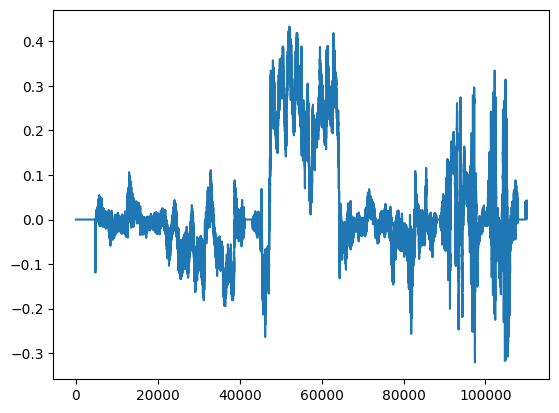

In [6]:
plt.plot(f_vy(time_pose))

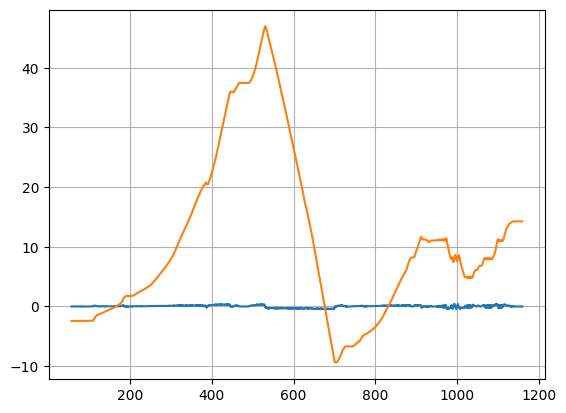

In [7]:
fig = plt.figure()
# plt.plot(f_vx(time_pose))
plt.plot(time_pose, f_wz(time_pose))

plt.plot(time_pose, f_yaw(time_pose))
# plt.plot(-f_steering(time_pose)/20)
plt.grid()
plt.show()

In [16]:
t = time_pose
state_measured = f_ax(t)
class ShattleXbr(System):
    def __init__(self):
        torque = SX.sym('torque')
        xbr = SX.sym('xbr')
        self.input_signals = torque, xbr

    def get_input_signals(self, t):
        return [f_actual_torque(t), f_xbr(t)]
    
    def observation(self):
        torque, xbr = self.input_signals
        k1, k2, R1, R2, R = SX.sym('k1'), SX.sym('k2'), SX.sym('R1'), SX.sym('R2'),  SX.sym('R')
        R_curr =  ca.if_else(xbr < 0, R2, R1)
        acc = k1*torque + k2*xbr + R + R_curr
        return vertcat(torque, xbr), vertcat(k1, k2, R1, R2, R), acc
    
regressor = Regressor(ShattleXbr())
theta = np.zeros(5)
for i in range(8):
    J, R = regressor.solve(theta, state_measured, t)
    H = J.T@J
    delta_theta_estimate = np.linalg.pinv(H + 0.1*np.diag(np.diag(H)))@J.T@R
    theta = theta + delta_theta_estimate
    print(theta)


NameError: name 'f_ax' is not defined

[0 1 0]
[-0.4935506   0.90282203 -0.01504619]
[-0.42874783  0.8872443  -0.02066753]
[-0.38591367  0.88387588 -0.02087708]
[-0.37088233  0.88293744 -0.020893  ]


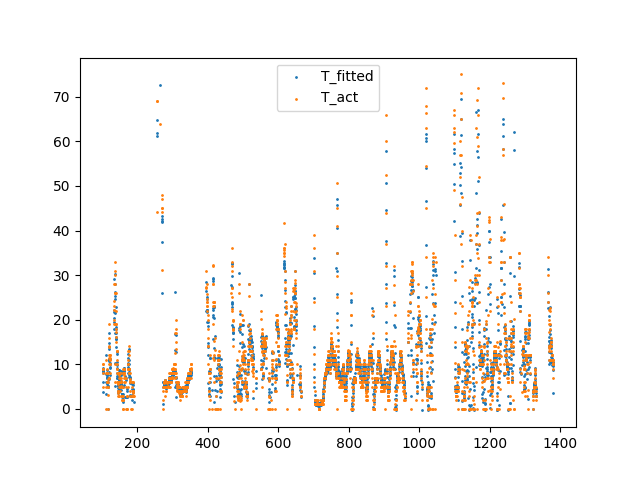

In [14]:
time = np.linspace(data_storage.t1, data_storage.t2, int((data_storage.t2-data_storage.t1)*3.0))

t_acc = time[np.where(np.logical_and.reduce([time > 0,  time < 130000, f_req_torque(time)>0, f_vx(time)>0]))]
state_measured = f_actual_torque(t_acc)

class ShattleTorque(System):
    def __init__(self):
        T_in = SX.sym('T_in')
        v = SX.sym('v')
        self.input_signals = T_in, v

    def get_input_signals(self, t):
        return [f_req_torque(t), f_vx(t)]
    
    def observation(self):
        T_in, v = self.input_signals
        a0, a1, a2 = SX.sym('a0'), SX.sym('a1'), SX.sym('a2')
        T_out = a0 + a1*T_in/(ca.sqrt(1 + a2*v*v))
        return vertcat(T_in, v), vertcat(a0, a1, a2), T_out
    
regressor = Regressor(ShattleTorque())
theta = np.array([0, 1, 0])
for i in range(5):
    J, R = regressor.solve(theta, state_measured, t_acc)
    H = J.T@J
    delta_theta_estimate = np.linalg.inv(H + 0.1*np.diag(np.diag(H)))@J.T@R
    print(theta)
    theta = theta + delta_theta_estimate

plt.clf()
fig = plt.figure()
plt.scatter(t_acc, regressor.h_x(t_acc, theta), label = 'T_fitted', s = 1)
plt.scatter(t_acc, state_measured, label = 'T_act', s = 1)
#plt.scatter(t_acc, f_req_torque(t_acc),  label = 'T_req', s = 1)

plt.legend()

In [34]:
t = time_pose[np.where(np.logical_and(time_pose > 200, f_vx(time_pose)>0))][::3]
state_measured_batch1 = f_wz(t)
class ShattleLateral(System):
    def __init__(self):
        steer = SX.sym('steer')
        v = SX.sym('v')
        self.GR = SX.sym('GR')
        self.offset = SX.sym('GR')
        self.input_signals = steer, v
        self.wheelbase  = 5.115 
        #x_grid = np.array([-800, -400, 0, 400, 800], dtype=np.float64)
        self.x_grid = np.linspace(-750, 750, 7)
        self.f_interp, self.y_values = get_interpolation_symbolic(self.x_grid, steer)
    
    def observation(self):
        steer, v = self.input_signals
        
        if(0):
            delta = np.pi *(steer * self.GR)/180.0 + self.offset
            coefs = vertcat(self.GR, self.offset)
        else:
            GR = self.f_interp(steer, self.y_values)
            delta = np.pi *(GR)/180.0
            coefs = vertcat(self.y_values)

        w = v * (ca.tan(delta)) / (self.wheelbase)
        return vertcat(steer, v), coefs, w
    
    
    def get_input_signals(self, t):
        return [f_steering(t)/1.0, f_vx(t)]
    
regressor = Regressor(ShattleLateral())



theta = np.zeros(regressor.theta_len)


n = len(regressor.system.x_grid)
Qdiff = np.eye(n-1, n, k=1) - np.eye(n-1, n)
#Qdiff = np.pad(Qdiff,((0,1), (0, 1)), mode='constant', constant_values=0)

P = Qdiff.T@Qdiff
for i in range(5):
    J, R = regressor.solve(theta, state_measured_batch1, t)
    H = J.T@J
    print(np.linalg.norm(R))
    delta_theta_estimate = np.linalg.pinv(H + 0.1*np.diag(np.diag(H)))@J.T@R
    theta = theta + delta_theta_estimate
    print(theta)


35.72862726996983
[0. 0. 0. 0. 0. 0. 0.]
35.72862726996983
[0. 0. 0. 0. 0. 0. 0.]
35.72862726996983
[0. 0. 0. 0. 0. 0. 0.]
35.72862726996983
[0. 0. 0. 0. 0. 0. 0.]
35.72862726996983
[0. 0. 0. 0. 0. 0. 0.]


In [33]:
1/0.05017687

19.929501381811978

In [ ]:
# time_pose = data_storage_lateral.get_time('vx')
# time_pose = time_pose[np.where(np.logical_and.reduce([time_pose >= data_storage_lateral.t1,  time_pose < data_storage_lateral.t2]))]

# f_actual_torque = data_storage_lateral.get_f_interp("actual_torque")
# f_req_torque = data_storage_lateral.get_f_interp("req_torque")
# f_xbr = data_storage_lateral.get_f_interp("xbr_request")
# f_vx = data_storage_lateral.get_f_interp("vx")
# f_wz = data_storage_lateral.get_f_interp("wz")
# f_steering = data_storage_lateral.get_f_interp("steering")

NameError: name 'regressor' is not defined

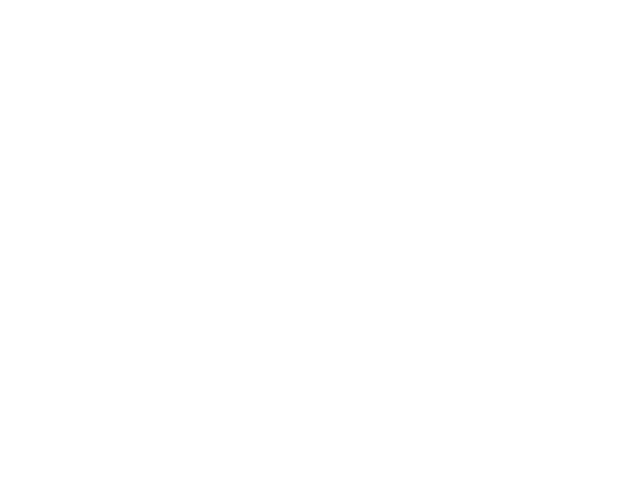

In [4]:
%matplotlib ipympl
#plt.clf()
fig = plt.figure()
err = f_wz(time_pose) - regressor.h_x(time_pose, theta)

plt.plot(time_pose, regressor.h_x(time_pose, theta), label = 'predicted')
plt.plot(time_pose, f_wz(time_pose), label = 'imu')

# plt.hist(err, bins = 100, label = 'predicted')
# plt.hist(err_old, bins = 100, label = 'old')
plt.legend()
plt.show()


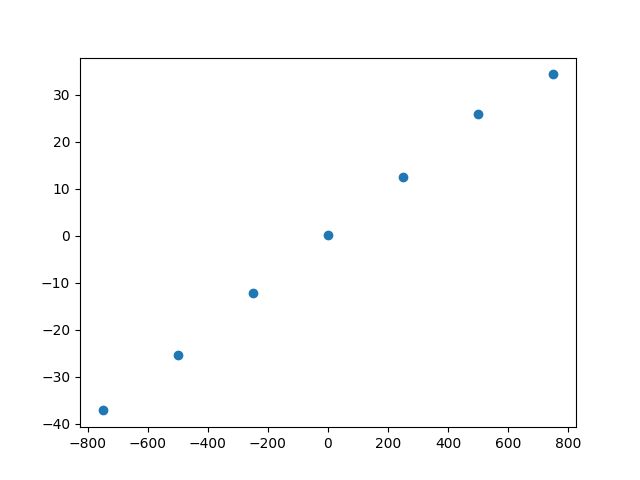

In [36]:
plt.clf()
fig = plt.figure()
plt.scatter(regressor.system.x_grid,  theta[:])
#plt.plot([regressor.system.x_grid[0], regressor.system.x_grid[-1]],  [theta[0], theta[-1]])

In [5]:

class TorqueControl(System):
    def __init__(self):
        self.state = [SX.sym('v')]
        self.input_signals = [SX.sym('T_in')]
        self.theta = [SX.sym('k_acc'), SX.sym('R')]
        
    def get_system(self):
        T_in = self.input_signals[0]
        v = self.state[0]
        k_acc, R = self.theta
        v_dot = k_acc * T_in - R
        return [*self.state], [*self.input_signals], [*self.theta], v_dot
    

class TorqueControlLong(System):
    def __init__(self):
        v_sym = SX.sym('v')
        torque = SX.sym('torque')
        xbr = SX.sym('xbr')
        delta = SX.sym('delta')
        pitch = SX.sym('pitch')
        self.state = [v_sym]
        self.input_signals = [torque, xbr, delta,  pitch]
        
        self.x_grid = np.linspace(0, 70, 20)
        self.f_interp, self.coefs_interp = get_interpolation_symbolic(self.x_grid, torque, 'coefs1')
        self.x_grid2 = np.linspace(-3, 0, 20)
        #self.x_grid2 = np.linspace(0, 12, 20)
        self.f_interp2, self.coefs_interp2 = get_interpolation_symbolic(self.x_grid2, xbr, 'coefs2')
        # self.f_interp2, self.coefs_interp2 = get_interpolation_symbolic(x_grid, steer, 'coefs2')
        self.theta = [SX.sym('k_acc'), SX.sym('k_dec'), SX.sym('R'), SX.sym('R1'), SX.sym('R2'),  SX.sym('g')]
        
    # def get_system(self):
    #     torque, xbr, delta, pitch = self.input_signals
    #     v = self.state[0]
    #     k_acc, k_dec, R, R1, R2, g = self.theta
    #     delra_rad = np.pi*delta/180.0
    #     R = self.f_interp(v, self.coefs_interp)
    #     #v_dot = k_acc * torque*np.cos(delra_rad) + 10*k_dec * xbr - R - 9.8*pitch * K_pitch - K_v * v - torque*K_delta*(1 + K_delta1*K_delta)#0*np.sin(pitch)
    #     R_xbr_torque =  ca.if_else(xbr < 0, R2, R1)
    #     v_dot = k_acc * ca.cos(delra_rad)*torque + k_dec * xbr - R - R_xbr_torque + g*np.sin(pitch)#- torque*K_delta*(1 + K_delta1*delra_rad)
    #     #v_dot = k_acc * torque + 10*k_dec * xbr - R - 9.8*pitch * K_pitch 
    #     return vertcat(*self.state), vertcat(*self.input_signals), vertcat(*self.theta, self.coefs_interp), v_dot 
    #    
    # def get_system(self):
    #     torque, xbr, delta, pitch = self.input_signals
    #     v = self.state[0]
    #     k_acc, k_dec, R, R1, R2, g = self.theta
    #     delra_rad = np.pi*delta/180.0
    #     #v_dot = k_acc * torque*np.cos(delra_rad) + 10*k_dec * xbr - R - 9.8*pitch * K_pitch - K_v * v - torque*K_delta*(1 + K_delta1*K_delta)#0*np.sin(pitch)
    #     R_xbr_torque =  ca.if_else(xbr < 0, R2, R1)
    #     v_dot = k_acc * ca.cos(delra_rad)*torque + k_dec * xbr - R - R_xbr_torque + g*np.sin(pitch)#- torque*K_delta*(1 + K_delta1*delra_rad)
    #     #v_dot = k_acc * torque + 10*k_dec * xbr - R - 9.8*pitch * K_pitch 
    #     return vertcat(*self.state), vertcat(*self.input_signals), vertcat(*self.theta), v_dot    
    
    def get_system(self):
        torque, xbr, delta, pitch = self.input_signals
        v = self.state[0]
        #k_acc, k_dec, R, R1, R2 = self.theta
        delra_rad = np.pi*delta/180.0
        R =  SX.sym('R')
        F_acc = self.f_interp(torque, self.coefs_interp)
        F_dec = self.f_interp2(xbr, self.coefs_interp2)
        #v_dot = k_acc * torque*np.cos(delra_rad) + 10*k_dec * xbr - R - 9.8*pitch * K_pitch - K_v * v - torque*K_delta*(1 + K_delta1*K_delta)#0*np.sin(pitch)
        #R = SX.sym('R')
        v_dot = F_acc + F_dec*xbr - R  #- torque*K_delta*(1 + K_delta1*delra_rad)
        #v_dot = k_acc * torque + 10*k_dec * xbr - R - 9.8*pitch * K_pitch 
        return vertcat(*self.state), vertcat(*self.input_signals), vertcat(self.coefs_interp, self.coefs_interp2, R), v_dot    




In [17]:
# class ShattleTorqueControl(TorqueControlLong):
#     def get_input_signals(self, t):
#         return [f_actual_torque(t + 0.15), f_xbr(t + 0.05)] 
        
# system = SystemJacobian(ShattleTorqueControl())
# s = ShattleTorqueControl()
# s()
#state_var, inp_signal_var, theta_var, f = s()
# len(state_var.elements())
# len(theta_var.elements())
# inp_signal_var.elements()


In [39]:
t = time_pose[np.where(np.logical_and.reduce([time_pose > 950, f_vx(time_pose) > 0]))]
t_eval_measurements_batches, state_measured_batches = create_interval_batches(t, f_yaw, max_delta_t = 1.0, min_interval = 3.0)
len(state_measured_batches)

class Kinematik_Bicycle(System):
    def __init__(self):
        self.input_signals = SX.sym('steer'), SX.sym('vx')
        self.state = SX.sym('psi')
        self.GR = SX.sym('GR')

    
    def get_system(self):
        steer, vx = self.input_signals
        delta = np.pi *(steer*self.GR)/180.0 
        w = vx * (ca.tan(delta)) / (5.115)
        psi_dot = w
        return self.state, vertcat(steer, vx), self.GR, psi_dot
    
    def observation(self):
        return self.state
    
class Shuttle_Bicycle(Kinematik_Bicycle):
    def get_input_signals(self, t):
        return [f_steering(t), f_vx(t)] 
        

class Shuttle_Dynamic(Lateral_car_dynamic):
    def get_input_signals(self, t):
        return [0*np.deg2rad(f_steering(t))/19.6, f_vx(t)] 
    def observation(self):
        vy, wz = self.state
        observed = vertcat(vy, wz)
        return observed 


system = SystemJacobian(Shuttle_Dynamic(wheelbase=5.135), method = 'Radau')

(9614, 1)
(7924, 1)


In [29]:
from matplotlib.gridspec import GridSpec

    

#system = SystemJacobian(Shuttle_Bicycle())

# STATE_LENGTH, THETA_LENGTH, MEAS_LEN = system.get_dimentions()
# theta = np.zeros(THETA_LENGTH)
# # theta[0] = -1.55
# # theta[1] = -59.5
# # theta[2] = 8.72
# # theta[3] = 22.06
# # theta = np.array([-14.19678799, -16.59699972,   4.88225968,   5.10883368])
# theta = np.array([ 3.90697911, -3.61844364, 11.46438743, 10.16318852])
# #theta = 10*(np.random.random(4) - 0.5)heta = np.zeros(THETA_LENGTH)
# assert len(theta) == THETA_LENGTH

def prepare_real_data():
    time = time_pose
    t_used = time_pose[np.where(np.logical_and.reduce([time_pose > 950, time_pose < 1050, f_vx(time_pose) > 1.0]))]
    delta_t = 0.05*0
    func_full = lambda t: np.array([f_vy(t), f_wz(t+delta_t)])
    t_eval_measurements_batches, state_full_batches = create_interval_batches(t_used, func_full, max_delta_t = 1.0, min_interval = 3.0)
    func_meas = lambda t: np.array([f_wz(t + delta_t)])
    func_meas = func_full
    t_eval_measurements_batches, state_measured_batches = create_interval_batches(t_used, func_meas, max_delta_t = 1.0, min_interval = 3.0)
    return t_eval_measurements_batches, state_measured_batches, state_full_batches


def prepare_sintetic_data(system: SystemJacobian, c0, theta, time_intervals):
    STATE_LENGTH, THETA_LENGTH, MEAS_LEN = system.get_dimentions()
    assert len(c0) == STATE_LENGTH
    assert len(theta) == THETA_LENGTH

    state_measured_batches = []
    state_full_batches = []
    t_eval_measurements_batches = []

    for (t_s, t_f) in time_intervals:
        t_eval_measurements, state_full  = generate_sintetic_data(system, c0_true=c0*(1 + 3*(np.random.random() - 0.5)) , N_measurement = 200, theta_true = theta, t_s = t_s, t_f = t_f, sigma = 0.0001)
        state_measured = np.zeros((len(state_full), MEAS_LEN))
        for i, state in enumerate(state_full):
            state_measured[i] = system.h_x(state, t_eval_measurements[i], theta)
        
        t_eval_measurements_batches.append(t_eval_measurements)
        state_measured_batches.append(state_measured)
        state_full_batches.append(state_full)
    return t_eval_measurements_batches, state_measured_batches, state_full_batches


def plot_solution(problem: MultipleShooting, theta_full,  THETA_HIST):    
    k = len(problem.t_eval_measurements_batches)
    fig = plt.figure(figsize=(30, 15))
    gs = GridSpec(4, k, figure=fig, hspace = 0.2, wspace = 0.1)
    if( 1 or MEAS_LEN > 1):
        ax1 = fig.add_subplot(gs[0, :])
        ax1.legend()
        ax1.grid(True)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')

    ax2 = fig.add_subplot(gs[3, :])
    axes_f = []
    axes_s = []
    for i in range(len(state_measured_batches)):
        ax = fig.add_subplot(gs[1, i])
        ax.grid(True)
        ax.set_xlabel('time, s')
        ax.set_ylabel('x')
        axes_f.append(ax)
        
        ax = fig.add_subplot(gs[2, i])
        ax.set_xlabel('time, s')
        ax.set_ylabel('y')
        ax.grid(True)
        axes_s.append(ax)
        
    t_eval_measurements_batches_valid, state_measured_batches_valid = problem.t_eval_measurements_batches, problem.state_full_batches# create_interval_batches(t_valid,f_vx, max_delta_t = 1.0, min_interval=4.0)
    for batch, (state_measured, t_eval_measurements) in enumerate(zip(state_measured_batches_valid, t_eval_measurements_batches_valid)):
        print(f'batch {batch}')
        N_measurement = len(t_eval_measurements)
        measurement_indexes = np.arange(0, N_measurement, 1, dtype=int )
        shoot_indexes = measurement_indexes[0:-1:int(len(measurement_indexes)/N_shoot)]
        shoot_indexes = np.append(shoot_indexes, measurement_indexes[-1])
        for shoot in range(min(len(shoot_indexes) -1, 100)):
            print(f'shoot {shoot}')
            if(VALIDATION):
                c0 = state_full[shoot_indexes[shoot]]
                time_manger = TimeIntervalManager(N_shoot, t_eval_measurements)
                t_eval_curr,  _  = time_manger.get_time_interval(shoot)
            else:
                c0 = theta_full[THETA_LENGTH + (N_shoot) * batch * STATE_LENGTH + shoot * STATE_LENGTH : THETA_LENGTH + (N_shoot) * batch * STATE_LENGTH +  (shoot + 1) * STATE_LENGTH]
                t_eval_curr, _ = problem.get_time_interval(shoot, batch)
                

            solution = system.get_solution_jax(c0, theta_full[:THETA_LENGTH], t_eval_curr)
            state_observed = np.zeros((solution.T.shape[0], 2))
            for i, state in enumerate(solution.T):
                state_observed[i] = state  #system.h_x(state,  t_eval_curr[i], theta_full[:THETA_LENGTH])

            axes_f[batch].plot(t_eval_curr, state_observed[:, 0])
            if(state_observed.shape[1] > 1):
                ax1.plot(state_observed[:, 0], state_observed[:, 1])
                axes_s[batch].plot(t_eval_curr, state_observed[:, 1])
        

        axes_f[batch].scatter(t_eval_measurements, state_measured[:, 0],  color='green',  marker='x',  s=1)
        if(state_measured.shape[1] > 1):
            ax1.scatter(state_measured[:, 0] , state_measured[:, 1], color='green',  marker='x')
            axes_s[batch].scatter(t_eval_measurements, state_measured[:, 1],  color='green',  marker='x')

    plt.tight_layout()

    ax2.plot([*range(iter + 2)], np.array(THETA_HIST)[:, :THETA_LENGTH])
    ax2.set_xlabel('iter')
    ax2.legend()
    ax2.grid(True)
    plt.show()
    

0 solve batch {batch}
t solve 3.4358530044555664
Iter 0   --- R 0.002243796699200973
0 solve batch {batch}
t solve 1.544003963470459
Iter 1   --- R 0.0021182649395993206
0 solve batch {batch}
t solve 1.5040087699890137
Iter 2   --- R 0.0016269614869897145
0 solve batch {batch}
t solve 1.5576493740081787
Iter 3   --- R 0.0016122941092748598
0 solve batch {batch}
t solve 1.7014999389648438
Iter 4   --- R 0.0016121398739575021
0 solve batch {batch}
t solve 1.7795145511627197
Iter 5   --- R 0.0016122624677601084
0 solve batch {batch}
t solve 1.6455461978912354
Iter 6   --- R 0.001612060633329532
batch 0
shoot 0


/tmp/ipykernel_1799365/1373727973.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


shoot 1
shoot 2
shoot 3
shoot 4


/tmp/ipykernel_1799365/1373727973.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_1799365/1373727973.py:116: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


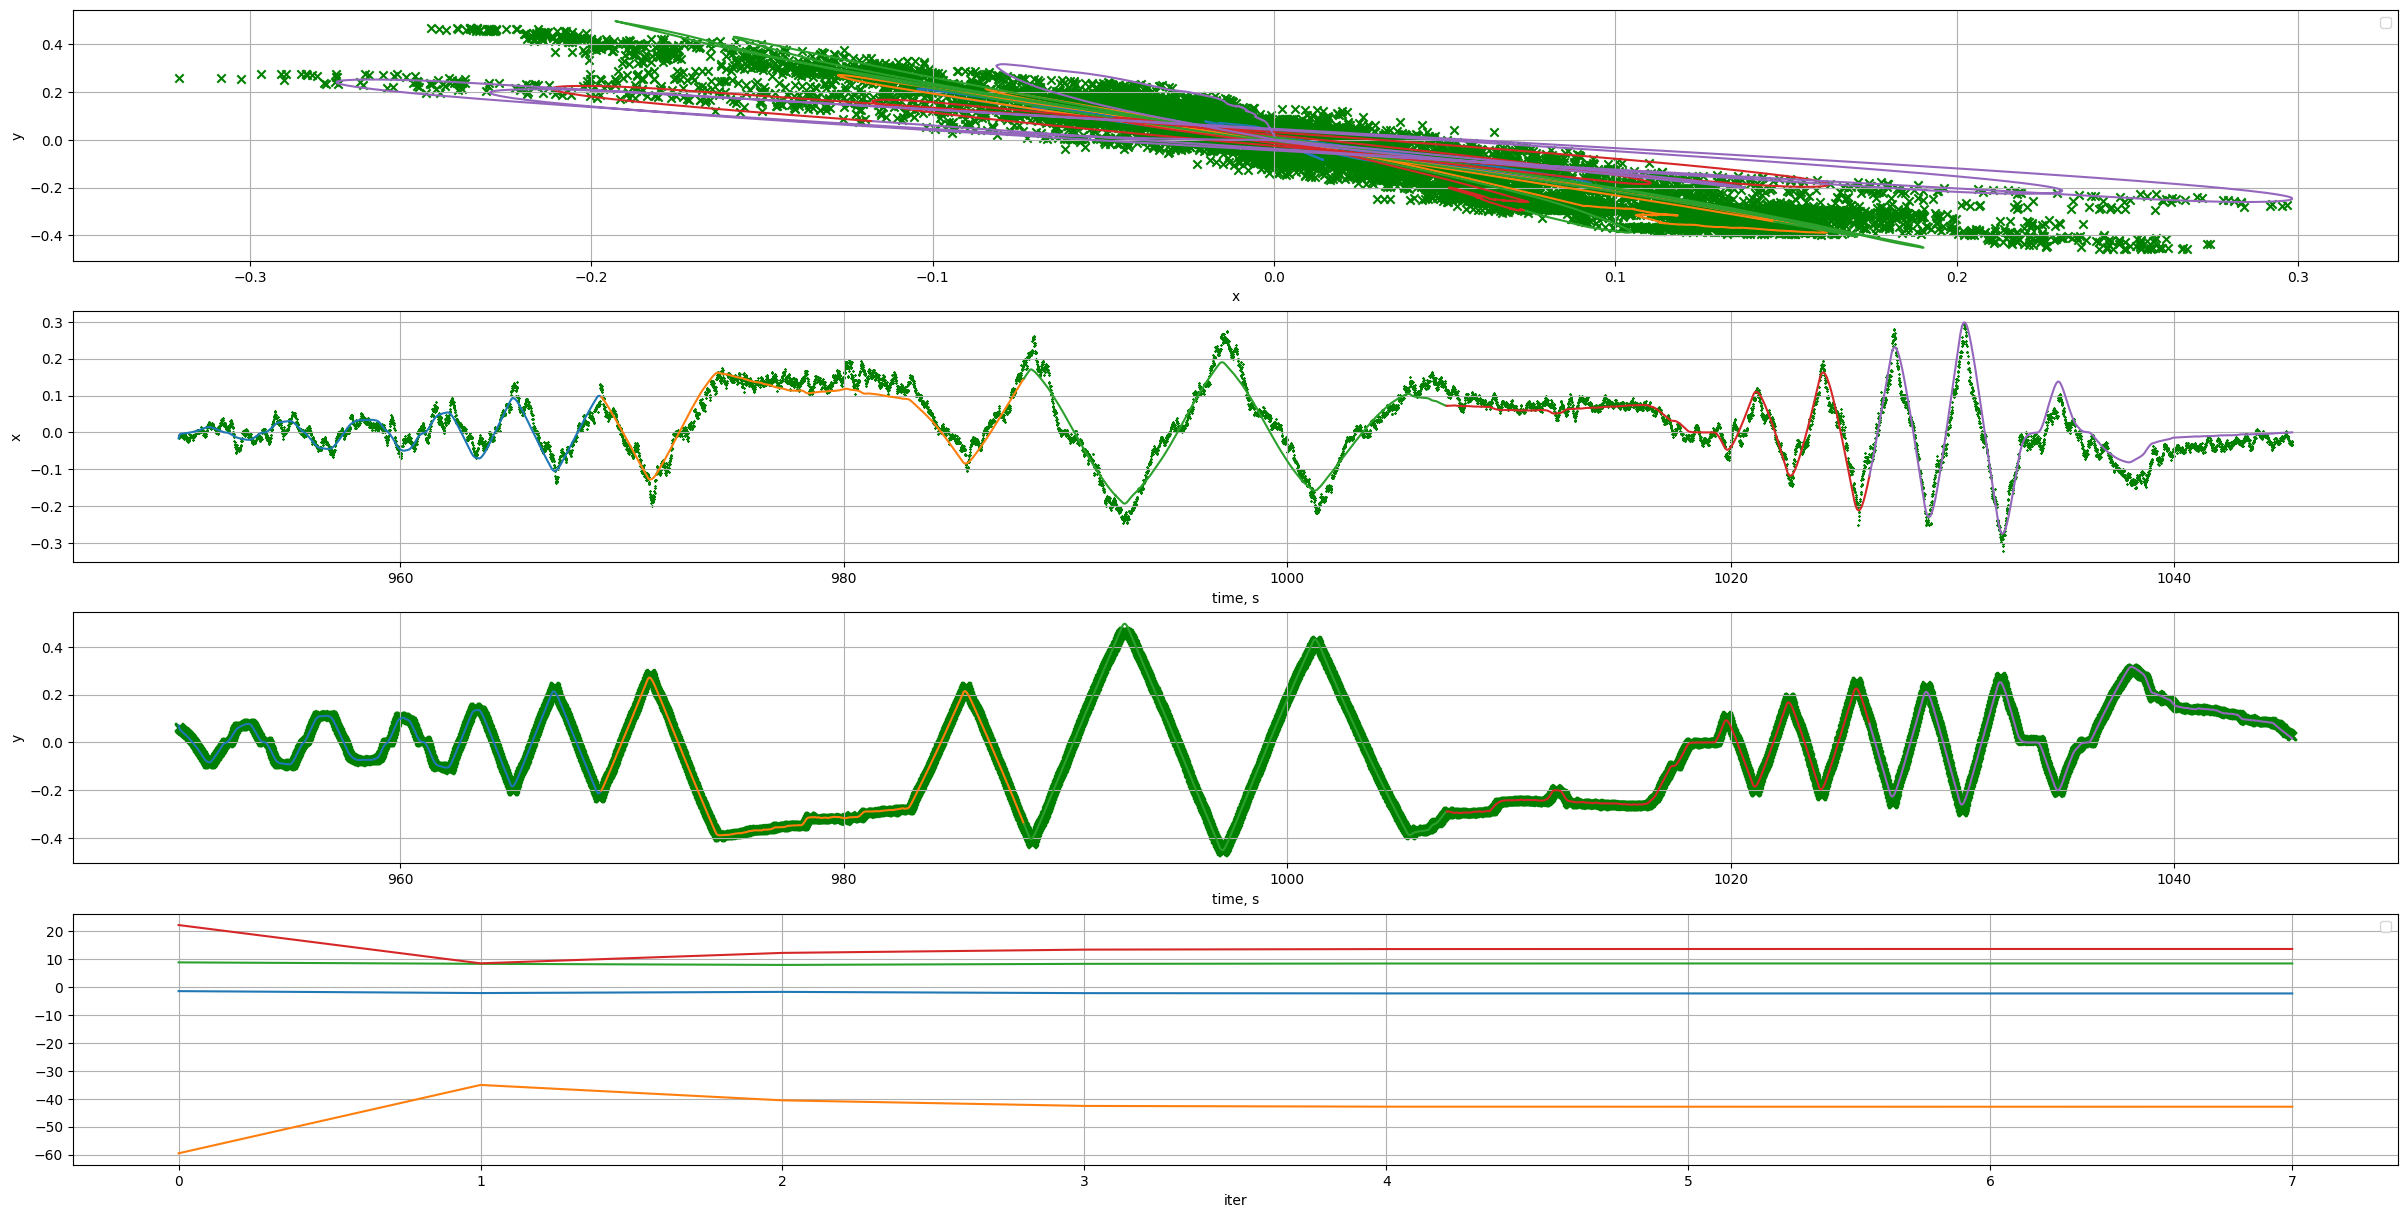

In [30]:


USE_SINTETIC_DATA  = 0
VALIDATION = 0

N_shoot = 5
N_iter = 7

if(USE_SINTETIC_DATA):
    if (1):
        sym_object = Lotka_voltera()
        theta_true = np.array([1.1, 0.4, 0.5, 0.1])
        c0 = np.array([10, 5]) 
        delta_theta = np.array([0.2, -0.11, 0.05, 0.01]) * 0.6
        theta = theta_true + delta_theta
    elif(0):
        sym_object = LateralSemiDynamic()  
        theta_true = np.array([1.1, 0.1])
        theta = theta_true*0.8
        c0 = np.array([0, 0, 0]) 
    elif(0):
        sym_object = Lateral_car_dynamic()
        theta_true = np.array([190.84329002394486, 53.12192057033912, 67.81308698534674, 75.97577338173109])
        theta = theta_true*0.1
        c0 = np.array([0, 0]) 
    elif(0):
        sym_object = Attractor()
        theta_true = np.array([0.14, 0.3, 0.4])
        theta = theta_true * 1.5
        c0 = np.array([1, 2, 1.2])   
        
    system = SystemJacobian(sym_object)
    t_eval_measurements_batches, state_measured_batches, state_full_batches = prepare_sintetic_data(system, c0, theta, [(20, 22), (44, 46)])
else:
    t_eval_measurements_batches, state_measured_batches, state_full_batches = prepare_real_data()

    class Shuttle_Dynamic(Lateral_car_dynamic):
        def get_input_signals(self, t):
            return [jnp.deg2rad(f_steering(t))/18.6, f_vx(t)]
        
        def observation(self):
            vy, wz = self.state
            observed = vertcat(vy, wz)
            #observed = vertcat( wz)
            return observed 
    
    system = SystemJacobian(Shuttle_Dynamic(wheelbase=5.135))

    STATE_LENGTH, THETA_LENGTH, MEAS_LEN = system.get_dimentions()
    theta = np.zeros(THETA_LENGTH)
    theta[0] = -1.55
    theta[1] = -59.5
    theta[2] = 8.72
    theta[3] = 22.06





gamma = np.ones(MEAS_LEN)
lambda_ = 0.01
R_norm = 1e8

# n = 20
# Qdiff = np.eye(n-1, n, k=1) - np.eye(n-1, n)
# D_diff = np.block([[Qdiff, np.zeros((n-1, n))],  [np.zeros((n-1, n)), Qdiff ]] )

problem = MultipleShooting(system, N_shoot, gamma, use_jax=1)
for state_measured, state_full, t_eval_measurements in zip(state_measured_batches, state_full_batches, t_eval_measurements_batches):
    problem.add_batch(state_full, state_measured, t_eval_measurements)

if(VALIDATION):
    N_iter = 0
else:
    theta_full = problem.make_full_theta(theta)
    THETA_HIST = [np.copy(theta_full[:])]
    
delta_theta_estimate = np.zeros_like(theta_full)
for iter in range(N_iter): 
    start = tm_module.time()
    H, R, R_norm_curr = problem.solve(theta_full)
    time_jax_compiled = tm_module.time() - start
    print("t solve" , time_jax_compiled)

    # D = np.pad(D_diff,((0, H.shape[0] - 40), (0, H.shape[0]  - 40)), mode='constant', constant_values=0)
    # Q = D.T@D
    delta_theta_estimate = (np.linalg.pinv(H + lambda_*np.diag(np.diag(H)))@R)[:len(theta_full)] 
    theta_full = theta_full + delta_theta_estimate
    # print("theta_full", theta_full)
    print(f'Iter {iter}   --- R {R_norm_curr}')
    THETA_HIST.append(np.copy(theta_full[:]))

    # if(np.abs(R_norm_curr - R_norm) < 1e-6):
    #     print(f'Iter {iter}   --- R {R_norm_curr}')
    #     print("solution converged")
    #     break

    # if(np.linalg.norm(R) - R_norm > 1e1):
    #     print(f'Iter {iter}   --- R {np.linalg.norm(R)}')
    #     print("solution disconverged")
    #     break
    R_norm = R_norm_curr




plot_solution(problem, theta_full, THETA_HIST)


In [32]:
 theta_full[:4]

array([ -2.37740699, -42.85712904,   8.33593155,  13.50878623])

In [33]:
# from matplotlib.gridspec import GridSpec
# t = time_pose[np.where(np.logical_and.reduce([time_pose > 0,time_pose < 3000, f_xbr(time_pose) <-0.0, np.abs(f_steering(time_pose)) < 50, f_vx(time_pose) >0, f_vx(time_pose) >5 ]))]
# t_batches, state_measured_batches = create_interval_batches(t, f_vx, max_delta_t=1.0, min_interval=3.0)
# print(len(t_batches))
# %matplotlib inline
# fig = plt.figure(figsize = (45, 15))
# gs = GridSpec(3, len(t_batches), figure=fig, hspace = 0.2, wspace = 0.1)


# axes = []
# axes2 = []
# axes3 = []
# for i in range(len(t_batches)):
#     axes.append(fig.add_subplot(gs[0, i]))
#     axes2.append(fig.add_subplot(gs[1, i]))
#     axes3.append(fig.add_subplot(gs[2, i]))

# for i, (t_batch, state_measured_batch) in enumerate(zip(t_batches, state_measured_batches)):

#     #plt.scatter(t_batch[:-1], 200*np.diff(state_measured_batch.T[0]))
#     #plt.scatter(t_batch, f_actual_torque(t_batch))
#     if(i < 70):

#         #plt.scatter(f_ax(t_batch), f_xbr(t_batch))
#         alfa = 0.1
        

#         vx =  f_vx(t_batch)
#         ax = np.diff(vx)/np.diff(t_batch)
#         ax = np.append(ax, ax[-1])

#         v_wheel = (f_wheel1(t_batch) + f_wheel2(t_batch) + f_wheel3(t_batch) + f_wheel4(t_batch))/(3.6*4)
#         ax2 = np.diff(v_wheel)/np.diff(t_batch)
#         ax2 = np.append(ax2, ax2[-1])

#         ax = first_order_filter(ax,alfa)
#         ax2 = first_order_filter(ax2,alfa)
#         torque = first_order_filter(f_actual_torque(t_batch), alfa)

#         xbr = f_xbr(t_batch - 0.16)
#         xbr = first_order_filter(xbr, alfa)
#         # plt.scatter(ax, xbr, s = 15)

        

#         axes[i].scatter(t_batch, xbr, s = 5, c = 'r', label = 'xbr')
#         axes[i].scatter(t_batch, ax, s = 5, c = 'g', label = r'$\frac{dv_x}{dt}$')
#         axes[i].scatter(t_batch, ax2, s = 5, c = 'b', label = r'$\frac{dv_{wheel}}{dt}$')
        
#         axes2[i].scatter(t_batch, f_vx(t_batch), s = 5, c = 'b', label = 'vx_pose')
#         axes2[i].scatter(t_batch, f_wheel1(t_batch)/3.6, s = 5, c = 'r',  label = 'wheelFR')
#         axes2[i].scatter(t_batch, f_wheel2(t_batch)/3.6, s = 5, c = 'g',  label = 'wheelFL')
#         axes2[i].scatter(t_batch, f_wheel4(t_batch)/3.6, s = 5, c = 'm',  label = 'wheelBR')
#         axes2[i].scatter(t_batch, f_wheel4(t_batch)/3.6, s = 5, c = 'k',  label = 'wheelBL')

#         # axes3[i].scatter(t_batch, f_steering(t_batch), s = 5, c = 'k')
#         slip1 = (f_wheel1(t_batch)/3.6 - vx)/vx
#         slip2 = (f_wheel2(t_batch)/3.6 - vx)/vx 
#         slip3 = (f_wheel3(t_batch)/3.6 - vx)/vx
#         slip4 = (f_wheel4(t_batch)/3.6 - vx)/vx
#         axes3[i].scatter(t_batch, -slip1, s = 5)
#         axes3[i].scatter(t_batch, -slip2, s = 5)
#         axes3[i].scatter(t_batch, -slip3, s = 5)
#         axes3[i].scatter(t_batch, -slip4, s = 5)

#         axes3[i].legend()
#         axes2[i].legend()
#         axes[i].legend()
#         axes[i].grid()  
#         axes2[i].grid() 
#         axes3[i].grid()   
#         axes[i].set_ylim(-3, 0)    
#         axes2[i].set_ylim(0, 10.5)   
#         axes3[i].set_ylim(-0.1, 1)   
#         axes2[i].set_xlabel("time, [s]")
#         axes[0].set_ylabel(r'$[m/s^2]$') 
#         axes2[0].set_ylabel(r'$[m/s]$') 
#         axes3[0].set_ylabel(r'$ sleep$') 

# # plt.xlabel(r'$a_x, m/s^2$')
# # plt.ylabel(r'$xbr$')
# plt.show()


In [50]:
MEAS_LEN

1

In [ ]:
state_measured_batches[0]

array([0.06619284, 0.0648171 , 0.06384838, ..., 0.02680825, 0.02657494,
       0.02563933], shape=(9531,), dtype=float32)

In [17]:
theta_full[:4]

array([-1116.54155561,  -999.92815527,   444.86155851,   384.77506438])

In [24]:
10*(np.random.random(4) - 0.5)

array([-0.79977436, -4.19435125,  1.59629598,  3.71154282])

In [ ]:
state_measured

array([0.06619284, 0.0648171 , 0.06384838, ..., 0.02680825, 0.02657494,
       0.02563933], shape=(9531,), dtype=float32)

In [7]:
time_manger = TimeIntervalManager(N_shoot, t_eval_measurements)
t0, t1, t_eval_curr, t_eval_curr_measur, _   = time_manger.get_time_interval(shoot)

In [9]:
t_eval_curr_measur

array([1026.24908471, 1026.26018929, 1026.26908922, ..., 1045.27979517,
       1045.28923798, 1045.29990125], shape=(1906,))

In [8]:
t_eval_curr

array([1026.24908471, 1026.29924691, 1026.3494091 , 1026.3995713 ,
       1026.44973349, 1026.49989569, 1026.55005788, 1026.60022008,
       1026.65038228, 1026.70054447, 1026.75070667, 1026.80086886,
       1026.85103106, 1026.90119325, 1026.95135545, 1027.00151764,
       1027.05167984, 1027.10184204, 1027.15200423, 1027.20216643,
       1027.25232862, 1027.30249082, 1027.35265301, 1027.40281521,
       1027.4529774 , 1027.5031396 , 1027.55330179, 1027.60346399,
       1027.65362619, 1027.70378838, 1027.75395058, 1027.80411277,
       1027.85427497, 1027.90443716, 1027.95459936, 1028.00476155,
       1028.05492375, 1028.10508595, 1028.15524814, 1028.20541034,
       1028.25557253, 1028.30573473, 1028.35589692, 1028.40605912,
       1028.45622131, 1028.50638351, 1028.55654571, 1028.6067079 ,
       1028.6568701 , 1028.70703229, 1028.75719449, 1028.80735668,
       1028.85751888, 1028.90768107, 1028.95784327, 1029.00800547,
       1029.05816766, 1029.10832986, 1029.15849205, 1029.20865

In [7]:
for batch, (state_measured, t_eval_measurements) in enumerate(zip(state_measured_batches_valid, t_eval_measurements_batches_valid)):
    print(f'batch {batch}')
    N_measurement = len(t_eval_measurements)
    measurement_indexes = np.arange(0, N_measurement, 1, dtype=int )
    shoot_indexes = measurement_indexes[0:-1:int(len(measurement_indexes)/N_shoot)]
    shoot_indexes = np.append(shoot_indexes, measurement_indexes[-1])
    for shoot in range(min(len(shoot_indexes) -1, 100)):
        print(f'shoot {shoot}')

        c0 = theta_full[THETA_LENGTH + (N_shoot) * batch * STATE_LENGTH + shoot * STATE_LENGTH : THETA_LENGTH + (N_shoot) * batch * STATE_LENGTH +  (shoot + 1) * STATE_LENGTH]
        t0, t1, t_eval_curr, t_eval_curr_measur, _ = problem.get_time_interval(shoot, batch)
        
        # t0, t1, t_eval_curr, t_eval_curr_measur, _   = time_manger.get_time_interval(shoot)
        print((t0, t1))
        print("c0", c0)
        solution = system.get_solution(0*c0, theta_full[:THETA_LENGTH], (t0, t1), t_eval_curr, t_eval_curr_measur)

batch 0
shoot 0
(np.float64(950.0065851211548), np.float64(998.0789346694946))
c0 [-0.01438795  0.06619283]
shoot 1
(np.float64(998.0789346694946), np.float64(1046.4196200370789))
c0 [ 0.12778895 -0.25458109]
batch 1
shoot 0
(np.float64(1057.7399551868439), np.float64(1097.359220981598))
c0 [0.00111892 0.01519616]
shoot 1
(np.float64(1097.359220981598), np.float64(1137.161906003952))
c0 [-0.0675521   0.27514395]
batch 2
shoot 0
(np.float64(1154.89191365242), np.float64(1156.911447763443))
c0 [ 0.02895147 -0.00207809]
shoot 1
(np.float64(1156.911447763443), np.float64(1158.9213242530823))
c0 [ 0.02370307 -0.00033114]


In [43]:
solution

(array([[ -0.01438795,  -0.0201005 ,  -0.0259466 , ..., -12.74903042,
         -12.76318488, -12.77734966],
        [  0.06619283,   0.06619283,   0.06619283, ...,   0.06619283,
           0.06619283,   0.06619283]], shape=(2, 961)),
 array([[ -0.01438795,  -0.01557151,  -0.01669699, ..., -12.76884729,
         -12.77171763, -12.77453473],
        [  0.06619283,   0.06619283,   0.06619283, ...,   0.06619283,
           0.06619283,   0.06619283]], shape=(2, 4807)))

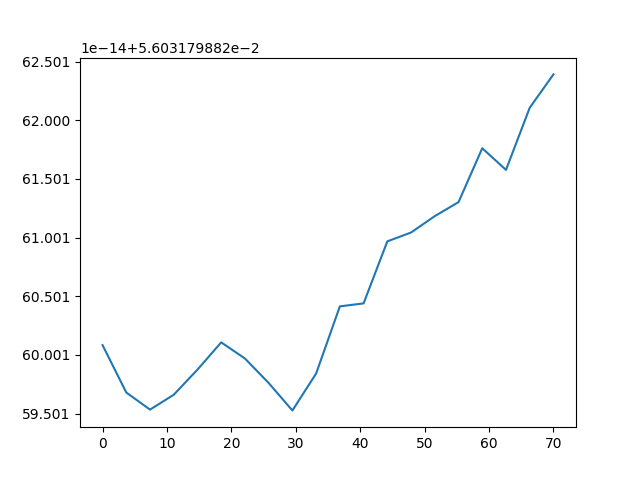

In [16]:
%matplotlib ipympl
plt.figure()
plt.plot(system.f_sym.x_grid, THETA_HIST[-1][:len(system.f_sym.x_grid)])   #0.0872
plt.show()


In [ ]:
import numpy as np
np.deg2rad  

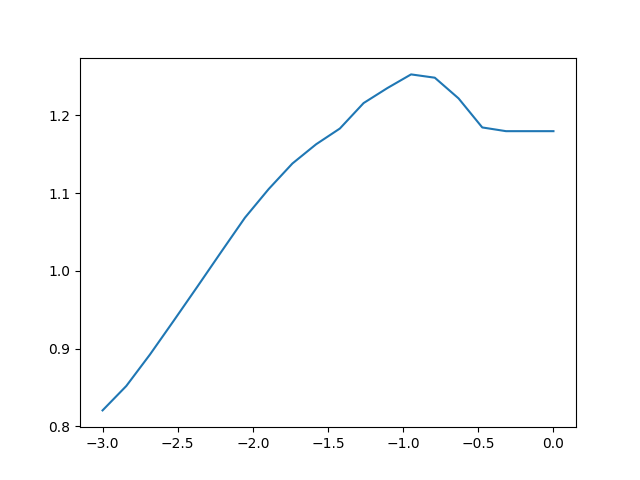

In [15]:

plt.figure()
plt.plot(system.f_sym.x_grid2, THETA_HIST[-1][len(system.f_sym.x_grid): len(system.f_sym.x_grid) + len(system.f_sym.x_grid2)]) 
plt.show()

In [8]:
THETA_HIST[-1]

array([ 0.01435343,  0.86759331,  0.02616253,  0.65084592,  8.2058499 ,
        1.0378625 ,  1.63485043,  0.0199117 ,  7.00991318,  0.52276698,
        3.23751311,  0.7389366 ,  8.67229224, -1.56177449,  2.48256475,
       -0.01600853,  7.37516505,  0.33253202,  6.59271779,  0.11267108,
        2.18421092,  0.23304809,  7.28494907,  0.18946869,  1.98481044])

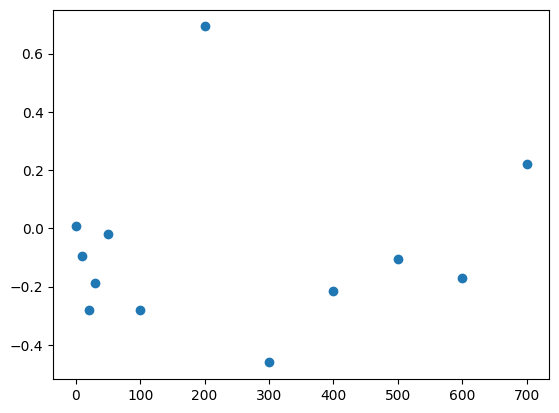

In [14]:


x_grid = system.f_sym.x_grid
plt.scatter(x_grid, THETA_HIST[-1][2:2+len(x_grid)])
#plt.scatter(x_grid, THETA_HIST[-1][11:21])

In [ ]:
for batch, (state_measured, t_eval_measurements) in enumerate(zip(state_measured_batches, t_eval_measurements_batches)):
    print(f'batch {batch}')
    print(state_measured.shape, t_eval_measurements.shape)

batch 0
(42, 1) (42,)
batch 1
(80, 1) (80,)
batch 2
(117, 1) (117,)
batch 3
(144, 1) (144,)
batch 4
(169, 1) (169,)
batch 5
(176, 1) (176,)
batch 6
(223, 1) (223,)


In [ ]:
t_eval_measurements_batches[0]

array([1230.09187253, 1230.19187857, 1230.29188462, 1230.39189067,
       1230.49189671, 1230.59190276, 1230.6919088 , 1230.79191485,
       1230.89192089, 1230.99192694, 1231.09193299, 1231.19193903,
       1231.29194508, 1231.39195112, 1231.49195717, 1231.59196322,
       1231.69196926, 1231.79197531, 1231.89198135, 1231.9919874 ,
       1232.09199344, 1232.19199949, 1232.29200554, 1232.39201158,
       1232.49201763, 1232.59202367, 1232.69202972, 1232.79203577,
       1232.89204181, 1232.99204786, 1233.0920539 , 1233.19205995,
       1233.29206599, 1233.39207204, 1233.49207809, 1233.59208413,
       1233.69209018, 1233.79209622, 1233.89210227, 1233.99210831,
       1234.09211436, 1234.19212041, 1234.29212645, 1234.3921325 ,
       1234.49213854, 1234.59214459, 1234.69215064, 1234.79215668,
       1234.89216273, 1234.99216877, 1235.09217482, 1235.19218086,
       1235.29218691, 1235.39219296, 1235.492199  , 1235.59220505,
       1235.69221109, 1235.79221714, 1235.89222319, 1235.99222

In [ ]:
def interpolate1d(x, x_bins):
    def find_nearest(value, array):
        # array = np.asarray(array)
        idx1 = (np.abs(array - value)).argmin()
        N = len(array) - 1
        if(array[idx1] >= value):
            return idx1 -1, idx1
        else:
            return idx1, idx1 + 1


    idx0, idx1 = find_nearest(x, x_bins)
    x0, x1 = x_bins[idx0], x_bins[idx1]
    #y0, y1 = y_bins[idx0], y_bins[idx1]
    f0, f1 = (x1 - x)/(x1 - x0), (x - x0)/(x1 - x0)
    #y = y0*f0 + y1*f1
    return np.array([idx0, idx1]), np.array([f0, f1])




NameError: name 'f2' is not defined

In [ ]:
time, f_delta, f_vx, f_wz, f_yaw, time_pose = get_new_log_data(20)

In [ ]:
coefs = THETA_HIST[-1][:THETA_LENGTH]

bins = np.array([-800, -400, 400, 800])
f_steer_delta = interpolate.interp1d(bins, coefs, kind='linear')
f_steer_delta_vova = interpolate.interp1d(np.array([-800.0, -455.1865, 389.9937, 800.0]), np.array([-41.5940, -24.9811, 19.7874, 40.1922]), kind='linear')



In [ ]:
coefs

array([-2859.34711711, -1301.59080105,  1188.01094512,  2600.2054566 ])

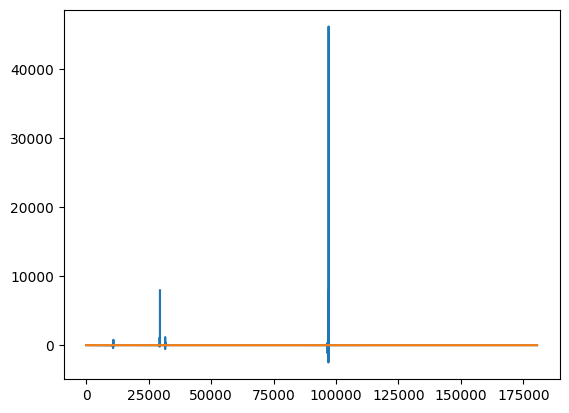

In [ ]:
plt.plot(np.tan(f_steer_delta(np.pi*f_delta(time_pose)/180))*f_vx(time_pose)/5.115)
plt.plot(f_wz(time_pose))

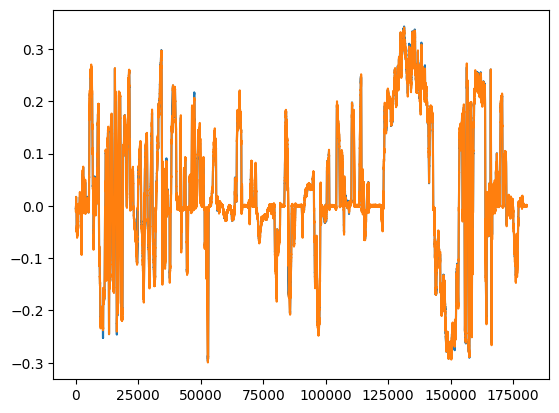

In [ ]:
plt.plot(np.tan(np.pi*f_steer_delta_vova(f_delta(time_pose))/180)*f_vx(time_pose)/5.115)
plt.plot(f_wz(time_pose))

In [ ]:
err_ilia = np.tan(np.pi*f_steer_delta(f_delta(time_pose))/180)*f_vx(time_pose)/5.115 - f_wz(time_pose)
err_vova = np.tan(np.pi*f_steer_delta_vova(f_delta(time_pose))/180)*f_vx(time_pose)/5.115 - f_wz(time_pose)


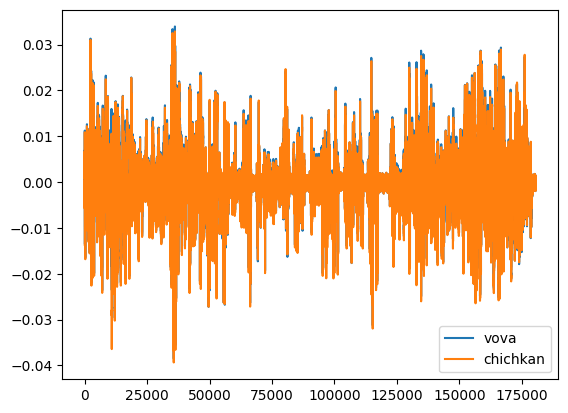

In [ ]:

plt.plot(err_vova,label = "vova")
plt.plot(err_ilia, label = "chichkan")
plt.legend()

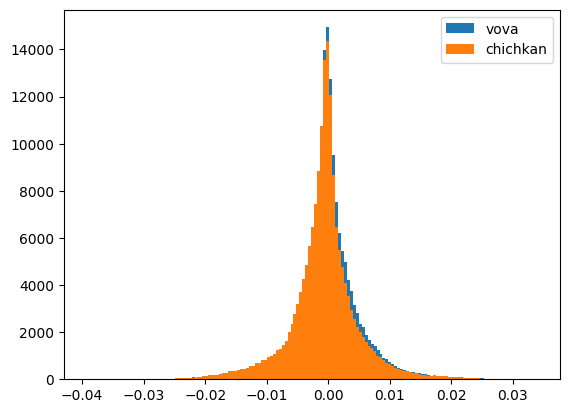

In [ ]:



plt.hist(err_vova, bins=150, label = "vova")
plt.hist(err_ilia, bins=150, label = "chichkan")
plt.legend()

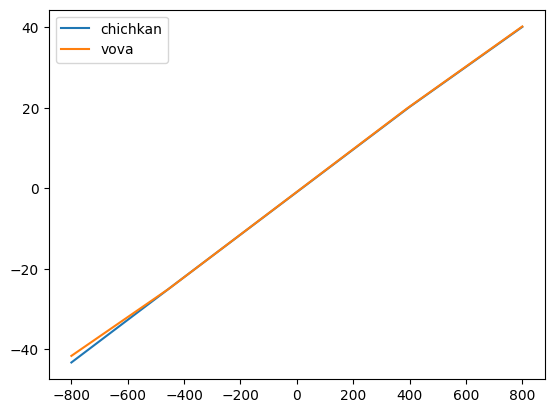

In [ ]:
plt.plot(bins, coefs, label = "chichkan")
plt.plot(np.array([-800.0, -455.1865, 389.9937, 800.0]), np.array([-41.5940, -24.9811, 19.7874, 40.1922]), label = "vova")
plt.legend()

In [ ]:
f_delta(t_batch1)*f_delta(t_batch1)

array([-5.38653320e+01, -3.40160000e+01, -2.53080930e+01, -2.59414804e+00,
       -3.04000000e-01, -3.04000000e-01,  1.32939708e+01,  7.64549422e+01,
        8.80000000e-02,  3.89310401e+01,  5.44920000e+01,  7.97756879e+01,
        6.13800000e+01,  7.86000000e+01,  8.80000000e-02,  8.80000000e-02,
        2.00000000e-01,  2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
        2.00000000e-01,  2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
        2.00000000e-01,  2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
        2.00000000e-01,  2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
        2.00000000e-01,  2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
        2.00000000e-01,  2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
        2.00000000e-01,  2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
        2.00000000e-01,  2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
        2.00000000e-01,  2.00000000e-01,  2.00000000e-01,  2.00000000e-01,
        2.00000000e-01,  

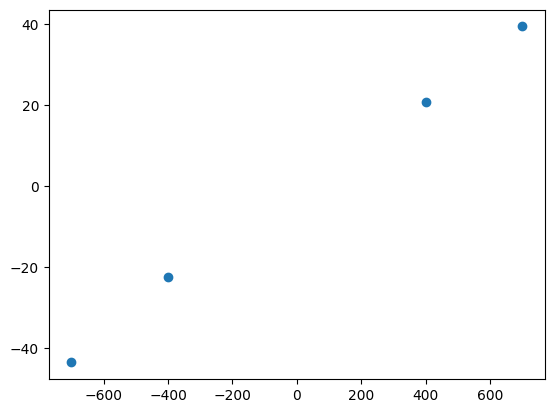

In [ ]:
plt.scatter(bins, coefs)

In [ ]:
800/(THETA_HIST[-1][1] - THETA_HIST[-1][0])

17.97674046103682

In [ ]:
1/THETA_HIST[-1][0], THETA_HIST[-1][1]

(17.97837907845269, -0.9237043853617021)

In [ ]:
t0, t1, t_eval_curr, t_eval_curr_measur, _ = problem.get_time_interval(2, batch)
solution1 = system.get_jacobian_solution(c0, theta_full[:THETA_LENGTH], (t0, t1), t_eval_curr, t_eval_curr_measur)[0]
solution2 = system.get_solution(c0, theta_full[:THETA_LENGTH], (t0, t1), t_eval_curr, t_eval_curr_measur)[0]

interpolation error, time 136829.71719286955
interpolation error, time 136829.71719286955


In [ ]:
solution2 = system.get_solution(c0, theta_full[:THETA_LENGTH], (t0, t1), t_eval_curr, t_eval_curr_measur)[0]

In [ ]:
system.f_x_theta(state, 2720, np.array([0.05174578, 0.000010706971]))

ValueError: A value (2720.0) in x_new is above the interpolation range's maximum value (2146.3210442066193).

In [ ]:
mysystem = lambda t, y: system.f_x_theta(y, t, np.array([0.05174578, 0.000010706971]))
solution1 = solve_ivp(
    mysystem,
    (1519.5078912064887, 1520.0), 
    c0,
    method='Radau' ,
    atol = 1e-6, rtol = 1e-6
)

ValueError: A value (446303351.3355573) in x_new is above the interpolation range's maximum value (2146.3210442066193).

In [ ]:
solution2.y.shape

(1, 990)

In [ ]:
theta_full[:THETA_LENGTH]

array([0.05170228, 0.10875026])

In [ ]:
1/THETA_HIST[-1][0]

32.55013715355446

In [ ]:
THETA_HIST[-1][1]

0.0009247604345919382

In [ ]:
state

array([16.70308805,  0.        ,  0.        ,  1.        ])

In [ ]:
t_batch1

array([1500.49904875, 1500.99928145, 1501.49951415, 1501.99974684,
       1502.49997954, 1503.00021223, 1503.50044493, 1504.00067763,
       1504.50091032, 1505.00114302, 1505.50137571, 1506.00160841,
       1506.50184111, 1507.0020738 , 1507.5023065 , 1508.0025392 ,
       1508.50277189, 1509.00300459, 1509.50323728, 1510.00346998,
       1510.50370268, 1511.00393537, 1511.50416807, 1512.00440076,
       1512.50463346, 1513.00486616, 1513.50509885, 1514.00533155,
       1514.50556425, 1515.00579694, 1515.50602964, 1516.00626233,
       1516.50649503, 1517.00672773, 1517.50696042, 1518.00719312,
       1518.50742581, 1519.00765851, 1519.50789121, 1520.0081239 ,
       1520.5083566 , 1521.00858929, 1521.50882199, 1522.00905469,
       1522.50928738, 1523.00952008, 1523.50975278, 1524.00998547,
       1524.51021817, 1525.01045086, 1525.51068356, 1526.01091626,
       1526.51114895, 1527.01138165, 1527.51161434, 1528.01184704,
       1528.51207974, 1529.01231243, 1529.51254513, 1530.01277

array([ 0.0681312 , -0.36651166])

In [ ]:
system.f_x_theta(c0, t1, np.array([ 0.0681312 , 0.13]))

array([0.26476604])

In [ ]:
solution = system.get_solution(c0, np.array([ 0.0681312 , 0.11]), (t0, t1), t_eval_curr, t_eval_curr_measur)

In [ ]:
1/THETA_HIST[-1][0]

18.407362830166818

In [ ]:
import numpy as np

np.random.seed(0) # псевдослучайные числа образуют одну и ту же последовательность (при каждом запуске)
x = np.arange(-1.0, 1.0, 0.1) # аргумент [-1; 1] с шагом 0,1

size_train = len(x)  # размер выборки
w = [0.5, -0.3]  # коэффициенты модели
model_a = lambda m_x, m_w: (m_w[1] * m_x + m_w[0])  # модель
loss = lambda ax, y: (ax - y) ** 2 # квадратическая функция потерь

y = model_a(x, w) + np.random.normal(0, 0.1, len(x)) # целевые значения

42

In [ ]:
theta_full

array([ 0.1       , -1.47440754, -0.87551814,  2.48764433])

In [ ]:
problem.system.get_jacobian_solution(c0, theta[:THETA_LENGTH], (t0, t1), t_eval_curr, t_eval_curr_measur)

(  message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 3.582e+02  3.583e+02 ...  3.597e+02  3.597e+02]
         y: [[ 2.303e+00  2.303e+00 ...  2.292e+00  2.292e+00]
             [ 0.000e+00 -1.593e-03 ... -1.120e-01 -1.158e-01]
             [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]]
       sol: None
  t_events: None
  y_events: None
      nfev: 158
      njev: 0
       nlu: 0,
   message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 3.582e+02  3.587e+02  3.592e+02]
         y: [[ 2.303e+00  2.299e+00  2.295e+00]
             [ 0.000e+00 -4.062e-02 -8.087e-02]
             [ 1.000e+00  1.000e+00  1.000e+00]]
       sol: None
  t_events: None
  y_events: None
      nfev: 158
      njev: 0
       nlu: 0)

In [ ]:
J_, J_G_, R_, R_G_ = problem.solve_batch(theta, state_measured, t_eval_measurements, 0)

ValueError: cannot reshape array of size 0 into shape (1,1)

In [ ]:
STATE_LENGTH, THETA_LENGTH, MEAS_LEN = problem.system.get_dimentions()
J = J_G = R = R_G = []
for batch, (state_measured, t_eval_measurements) in enumerate(zip(problem.state_measured_batches, problem.t_eval_measurements_batches)):
    print(batch, "solve batch {batch}")
    J_, J_G_, R_, R_G_ = problem.solve_batch(theta, state_measured, t_eval_measurements, batch)
    if(len(J) == 0):
        J = np.copy(J_)
        J_G = np.copy(J_G_)
        R = np.copy(R_)
        R_G = np.copy(R_G_)
    else:
        J = concantenate_jacobian(J, J_)
        J_G = concantenate_jacobian(J_G, J_G_)
        R = np.hstack((R, R_))
        R_G = np.hstack((R_G, R_G_))

H = J.T@J   
N_batches = len(problem.state_measured_batches)
H_big = np.block([[H, J_G.T], [J_G, np.zeros((J_G.shape[0], J_G.shape[0]))]])

R_big = np.concatenate((J.T@R, R_G))

0 solve batch {batch}


In [ ]:
H.shape
J_G.T.shape
J

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
def concantenate_jacobian(J1, J2):
    J2_theta = J2[:, :THETA_LENGTH]
    J2_c0 = J2[:, THETA_LENGTH:]
    zeros1 = np.zeros((J1.shape[0], J2_c0.shape[1]))#
    zeros2 = np.zeros((J2_theta.shape[0], J1.shape[1] - THETA_LENGTH))#
    #zeros1 = np.zeros_like(J2_c0)
    return np.block([[J1, zeros1], [J2_theta, zeros2, J2_c0]])

In [ ]:
STATE_LENGTH, THETA_LENGTH, MEAS_LEN = problem.system.get_dimentions()
J = J_G = R = R_G = []

J1, J_G1, R1, R_G1 = problem.solve_batch(theta, problem.state_measured_batches[0], problem.t_eval_measurements_batches[0], 0)
J2, J_G2, R2, R_G2 = problem.solve_batch(theta, problem.state_measured_batches[1], problem.t_eval_measurements_batches[1], 1)
J3, J_G3, R3, R_G3 = problem.solve_batch(theta, problem.state_measured_batches[2], problem.t_eval_measurements_batches[2], 2)

J = np.vstack((J1, J2, J3))
J_G = np.vstack((J_G1, J_G2, J_G2))



R = np.hstack((R1, R2, R2))
R_G = np.hstack((R_G1, R_G2, R_G2))

H = J.T@J   
N_batches = len(problem.state_measured_batches) 
H_big = np.block([[H, J_G.T], [J_G, np.zeros(((problem.N_shoot-1)* STATE_LENGTH * N_batches, N_batches * (problem.N_shoot-1)* STATE_LENGTH))]])
R_big = np.concatenate((J.T@R, R_G))

In [ ]:
J_big = concantenate_jacobian(J1, J2)
J_big2 = concantenate_jacobian(J_big, J3)
# J2_theta = J2[:, :THETA_LENGTH]
# J2_c0 = J2[:, THETA_LENGTH:]
# zeros1 = np.zeros((J1.shape[0], J2_theta.shape[1]))#
# zeros2 = np.zeros((J2_theta.shape[0], J.shape[1] - THETA_LENGTH))#

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 12 and the array at index 1 has size 15

In [ ]:
J2_theta = J2[:, :THETA_LENGTH]
J2_c0 = J2[:, THETA_LENGTH:]
zeros1 = np.zeros((J1.shape[0], J2_c0.shape[1]))#
zeros2 = np.zeros((J2_theta.shape[0], J1.shape[1] - THETA_LENGTH))#
np.block([[J1, zeros1], [J2_theta, zeros2, J2_c0]])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
J1.shape

(120, 9)

In [ ]:
zeros1.shape


(120, 3)

In [ ]:
J2_theta.shape, zeros2.shape, J2_c0.shape

((120, 3), (120, 6), (120, 6))

In [ ]:
zeros2 = np.zeros((J2_theta.shape[0], J1.shape[1] - THETA_LENGTH))#


(14, 14)

In [ ]:


H = J.T@J   
H_big = np.block([[H, J_G.T], [J_G, np.zeros( ((N_shoot-1)* STATE_LENGTH * 2,  2 * ( N_shoot-1)* STATE_LENGTH))]])
R_big = np.concatenate((J.T@R, R_G))

In [ ]:
np.vstack((t_eval_measurements, t_eval_measurements2)).shape

(2, 140)

In [ ]:
H, R = problem.solve(theta)

In [ ]:
np.hstack((H, H)).shape

(22, 44)

In [ ]:
t_eval_measurements, state_full, f_delta, f_vx  = get_log_data()

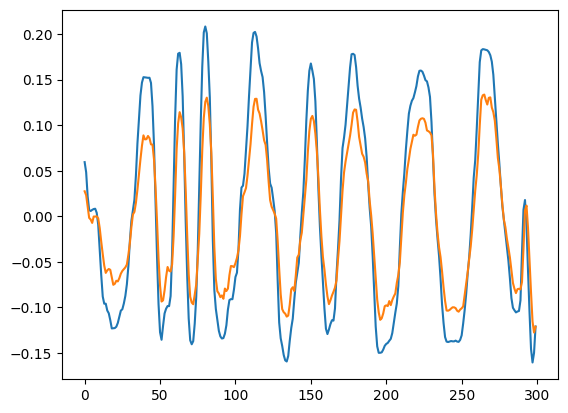

In [ ]:
w_ = f_delta(t_eval_measurements)*f_vx(t_eval_measurements)/(2.65*14)
plt.plot(w_)
plt.plot(state_full[:, 1])

In [ ]:
system.dh_dtheta(state, 0.8, theta[:THETA_LENGTH])

array([[0.],
       [0.]])

In [ ]:
np.array(system.res_h(*[*state, *system.f_sym.get_input_signals(30), *np.array([2])])).T[0]


array([0.14801641, 0.00299062])

In [ ]:
np.array(system.res_h(*[*state, delta[100], v[100], *theta1])).T[0]

array([-0.64065357, -0.02694448])

In [ ]:
print(system.f_sym.get_input_signals(t_eval_measurements[100]))
print(delta[100])
v[100]

[-0.048230106895237435, 14.83453237410072]
-0.048230106895237435


14.83453237410072

In [ ]:
theta1 = np.array([2.0])
theta2 = np.array([1.41])
t_eval_measurements1, state_full1  = generate_sintetic_data(system, c0_true=c0_true, theta_true = theta1, T_max = 23, sigma = 0.001)
t_eval_measurements2, state_full2  = generate_sintetic_data(system, c0_true=c0_true, theta_true=theta2, T_max = 23, sigma = 0.001)

state_measured1 = np.zeros((len(state_full1), MEAS_LEN))
for i, state in enumerate(state_full1):
    state_measured1[i] = system.h_x(state, t_eval_measurements[i], theta1)

state_measured2 = np.zeros((len(state_full2), MEAS_LEN))
for i, state in enumerate(state_full1):
    state_measured2[i] = system.h_x(state, t_eval_measurements[i], theta2)



delta, v = [], []
for t in t_eval_measurements:
    d_, v_ = sym_object.get_input_signals(t)
    delta.append(d_)
    v.append(v_)

v = np.array(v)
delta = np.array(delta)
state_measured1_ = np.zeros((len(state_full1), MEAS_LEN))
for i, state in enumerate(state_full1):
    state_measured1_[i] = np.array(system.res_h(*[*state, delta[i], v[i], *theta1])).T[0]





w1 = v * (delta) / (2.65 * theta1)
w2 = v * (delta) / (2.65 * theta2)

In [ ]:
np.array(system.res_h(*[*state, delta[i],v[i], *theta1])).T[0]

TypeError: 'float' object is not subscriptable

In [ ]:
[*[*state, delta[i],v[i], *theta1]]

TypeError: 'float' object is not subscriptable

In [ ]:
sym_object.get_input_signals(t_eval_measurements)

[0.03,
 array([15.        , 14.99834532, 14.99669065, 14.99503597, 14.99338129,
        14.99172662, 14.99007194, 14.98841727, 14.98676259, 14.98510791,
        14.98345324, 14.98179856, 14.98014388, 14.97848921, 14.97683453,
        14.97517986, 14.97352518, 14.9718705 , 14.97021583, 14.96856115,
        14.96690647, 14.9652518 , 14.96359712, 14.96194245, 14.96028777,
        14.95863309, 14.95697842, 14.95532374, 14.95366906, 14.95201439,
        14.95035971, 14.94870504, 14.94705036, 14.94539568, 14.94374101,
        14.94208633, 14.94043165, 14.93877698, 14.9371223 , 14.93546763,
        14.93381295, 14.93215827, 14.9305036 , 14.92884892, 14.92719424,
        14.92553957, 14.92388489, 14.92223022, 14.92057554, 14.91892086,
        14.91726619, 14.91561151, 14.91395683, 14.91230216, 14.91064748,
        14.90899281, 14.90733813, 14.90568345, 14.90402878, 14.9023741 ,
        14.90071942, 14.89906475, 14.89741007, 14.8957554 , 14.89410072,
        14.89244604, 14.89079137, 14.8891366

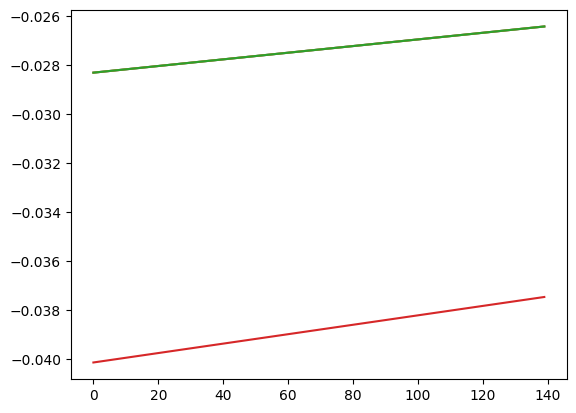

In [ ]:
plt.clf()
plt.plot(state_measured1[:, 1])
#plt.plot(state_measured1[:, 0])
plt.plot(state_measured2[:, 1])
# plt.plot(state_measured1_[:, 1])
plt.plot(w1)
plt.plot(w2)
#plt.plot(-w2/state_measured2[:, 1])
plt.show()

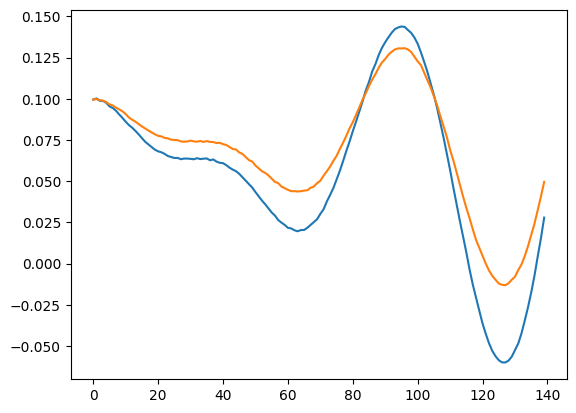

In [ ]:
plt.plot(state_full1)
plt.plot(state_full2)

In [ ]:
state_full1

array([[ 0.09972876],
       [ 0.09935493],
       [ 0.09936726],
       [ 0.09875963],
       [ 0.09775389],
       [ 0.09621571],
       [ 0.09434587],
       [ 0.09275903],
       [ 0.09052399],
       [ 0.08856062],
       [ 0.08666474],
       [ 0.08419822],
       [ 0.08199194],
       [ 0.08031598],
       [ 0.0775976 ],
       [ 0.0758457 ],
       [ 0.07423578],
       [ 0.07293985],
       [ 0.07068712],
       [ 0.06989115],
       [ 0.06818921],
       [ 0.06740167],
       [ 0.06591071],
       [ 0.06506611],
       [ 0.06456108],
       [ 0.06397841],
       [ 0.06431044],
       [ 0.06347155],
       [ 0.06404565],
       [ 0.06394631],
       [ 0.06349118],
       [ 0.06352539],
       [ 0.06390916],
       [ 0.06337328],
       [ 0.06310102],
       [ 0.06384215],
       [ 0.06309258],
       [ 0.06278635],
       [ 0.06194893],
       [ 0.06119382],
       [ 0.06095472],
       [ 0.05997089],
       [ 0.05816905],
       [ 0.05751407],
       [ 0.05558413],
       [ 0

In [ ]:
theta_true

array([2])

In [ ]:
system.dh_dtheta(state, 1.5, theta[:THETA_LENGTH])

array([[-0.93327401]])

In [ ]:
state_var, inp_signal_var, theta_var, f = system.f_sym()

In [ ]:
theta_var

[SX(GR)]

In [ ]:
state

array([0.08195559])

In [ ]:
H.shape

(14, 14)

In [ ]:
    H_big = np.block([[H, J_G.T], [J_G, np.zeros((12, 12))]])
    R_big = np.concatenate((J.T@R, R_G))

array([ 7.16220840e-05,  8.94197222e-05, -1.03823612e-04, -1.20072419e-03,
       -1.93643319e-06,  1.64878347e-06, -4.53387204e-07, -5.82329856e-07,
       -4.13556406e-07, -2.94031806e-06, -1.08388371e-07, -4.31439358e-06,
        4.88420883e-06,  5.07635126e-05,  1.70975422e+00,  1.19900172e-01,
        9.97867016e-02,  4.37001838e-01, -3.00625244e-01,  1.79341691e-01,
       -1.17099826e+00,  9.68930522e-03, -8.17929536e-01, -5.55105806e-01,
        0.00000000e+00,  0.00000000e+00])

In [ ]:
np.block([J_G, np.zeros((12, 14))])

array([[ 1.67206443e+00, -8.90571091e+00, -6.81285303e-02,
        -6.90879345e-01, -1.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.65141943e+00, -9.21484978e+00,  2.04209255e-01,
         1.67845014e-01, -0.00000000e+00, -1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00

In [ ]:
J_G.shape

(12, 14)

In [ ]:
J_G.shape
J_G.reshape((N_shoot + 1)*STATE_LENGTnp.blockH, -1)

array([[ 1.73897215e+00, -9.29338994e+00, -6.52098651e-02,
        -7.46185051e-01, -1.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.64430800e+00, -9.06233536e+00,  2.05407627e-01,
         1.92186050e-01, -0.00000000e+00, -1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.74337311e+00, -5.62146841e+00,  1.91448049e+00,
        -2.14335161e+00,  5.96138827e-01, -5.23585548e-01,
        -1.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 3.32126453e-01, -1.19212282e+00, -3.99108839e+00,
         4.19374069e+00,  2.67766475e-01,  4.29747411e-01,
        -0.00000000e+00, -1.00000000e+00,  0.

In [ ]:
len(shoot_indexes)

6

In [ ]:
sym_object = Lateral_car_dynamic(2, 5)
theta_true = np.array([190.84329002394486, 53.12192057033912, 67.81308698534674, 75.97577338173109, 0])

c0_true = np.array([0, 0]) 
        
system = SystemJacobian(sym_object)

In [ ]:
H = J.T@J 
np.diag(np.diag(H))

array([[1.74735874e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.77456230e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.00358975e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.81362359e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+0

In [ ]:
THETA_LENGTH

4

In [ ]:
R.reshape(N_measurement*STATE_LENGTH)

array([-3.57090086e-02,  3.57137714e-02, -2.96063625e-02,  1.63043883e-03,
       -2.21658690e-03, -5.19433819e-05,  5.41823113e-05,  1.58598793e-05,
        1.24494185e-04,  2.24264632e-06,  1.39831822e-04, -1.34729619e-05,
        1.68285954e-04, -1.77657117e-05,  2.27616421e-04, -2.80722738e-05,
        2.63115756e-04, -2.15840795e-05,  2.97818633e-04, -4.25137769e-05,
        3.30904321e-04, -6.05228905e-05,  3.55160422e-04, -5.71613749e-05,
        3.69275462e-04, -6.85137756e-05,  3.84092970e-04, -7.65052534e-05,
        4.08462918e-04, -9.20765526e-05,  4.25352497e-04, -9.46774841e-05,
        4.66165121e-04, -9.73627998e-05,  4.67953046e-04, -9.33312291e-05,
        5.05940936e-04, -1.04151018e-04,  4.97887661e-04, -1.17498532e-04,
        5.27504753e-04, -1.35430353e-04,  5.27036651e-04, -1.24919192e-04,
        5.52031244e-04, -1.20824747e-04,  5.35864168e-04, -1.39635442e-04,
        5.61009697e-04, -1.50476877e-04,  5.44659459e-04, -1.51007468e-04,
        5.68086624e-04, -

In [ ]:
theta = least_squares(fun= lambda theta: np.linalg.norm(Residual(theta)), x0 = theta, jac = lambda theta : Jacobian(theta).sum(axis=(0, 1)), loss='huber').x

shoot 0
shoot 1
shoot 2
shoot 3
shoot 4


In [ ]:
theta[:THETA_LENGTH]

array([ 99.38057394, -49.48725482,  47.90791074,  53.62117262])

In [ ]:
theta[:THETA_LENGTH][np.where(theta[:THETA_LENGTH] < 0)] = 0
theta[:THETA_LENGTH]


array([99.38057394,  0.        , 47.90791074, 53.62117262])

In [ ]:
Jac = lambda theta : Jacobian(theta).sum(axis=(0, 1))
Jac(theta)


shoot 0
shoot 1
shoot 2
shoot 3
shoot 4


array([ 0.17423353, -0.15344504, -1.3519532 ,  1.19414853,  0.22424225,
       -3.40923028, -0.77631689, -4.19156074, -0.77706973, -3.98170443,
       -0.77802699, -3.77976827, -0.74063306, -3.3209414 ])

In [ ]:
least_squares(fun= lambda theta: np.linalg.norm(Residual(theta)), x0 = theta, loss='huber').x

In [ ]:
fun= lambda theta: np.linalg.norm(Residual(theta))
fun(theta)

0.002564331821261424

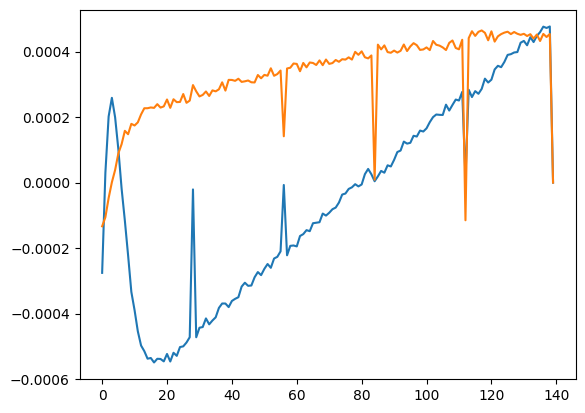

In [ ]:
plt.plot( R)
plt.show()

In [ ]:
theta[:4]

array([103.70121029, -46.81434828,  33.25179166,  36.45426644])

In [ ]:
vec_size = THETA_LENGTH + STATE_LENGTH * (len(shoot_indexes)-1)
bnds = [(None, None)]*vec_size
bnds[:THETA_LENGTH] = [(0, None)]*THETA_LENGTH

minimize(lambda theta_: np.linalg.norm(J@theta_ - R) , np.zeros(vec_size), bounds=bnds).x

array([ 0.00114905,  0.        ,  0.        ,  0.        , -0.00690161,
        0.00028878, -0.00110008, -0.00039462,  0.0044618 , -0.00116894,
        0.00408778, -0.00287543,  0.0084063 , -0.00230853])

In [ ]:
np.array([ 3.99854077e+01, -3.82827679e+01,  1.00699629e+01,  1.74764933e+01])

array([ 39.9854077, -38.2827679,  10.0699629,  17.4764933])

In [ ]:
theta_true

array([1.1, 0.4, 0.5, 0.1])

In [ ]:
m = 1580
J = 3650
a = 2.65/2
wheelbase = 2.65
Cf = 50*1e3
Cr = 50*1e3
b = wheelbase - a
a0 = (-a * b/J + 1.0/m)*Cf
a1 =  (-b * b/J - 1.0/m)*Cr
b0 = Cf*a/J
b1 = Cr*b/J
a0, a1, b0, b1


(7.595912086006589, -55.69522715449974, 18.15068493150685, 18.15068493150685)

In [ ]:
THETA_HIST

[array([0., 0., 0., 0.]),
 array([-26.2295923 , -22.97071138,  -2.81776346,  -2.63456917]),
 array([-29.69015544, -60.90931524,  -3.5165884 ,  -4.97479924]),
 array([ -59.40994981, -151.33054788,   -2.80855605,   -3.39508772]),
 array([-7.43169698e+01, -1.97530928e+02, -1.43163543e+00, -7.72625743e-02]),
 array([-7.43666246e+01, -1.97410843e+02, -1.14032291e+00, -1.94779199e-02])]

In [ ]:
ax1.set_xlabel('(x)')
ax1.set_ylabel('(y)')
ax1.scatter(state_measured[0, :] , state_measured[1, :], color='green',  marker='x')
ax1.legend()
ax1.grid()


ax2.set_xlabel('time')
ax1.set_ylabel('x')
ax2.legend()
ax2.grid()


ax3 = fig.add_subplot(3, 1, 3)
ax3.plot([*range(N_iter + 1)], np.array(THETA_HIST))
ax3.set_xlabel('iter')
ax3.legend()
ax3.grid()



plt.tight_layout()
plt.show()

/tmp/ipykernel_213880/1665339649.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipykernel_213880/1665339649.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()
/tmp/ipykernel_213880/1665339649.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


<Figure size 640x480 with 0 Axes>

In [ ]:
N_measurement


2

In [ ]:
t_eval_measurements.shape


(70,)

In [ ]:
state_measured[:, ind]

array([10.,  5.,  0.])

In [ ]:
np.array(state_sample[:, i] - state_measured[:, ind])

array([0., 0., 0.])

In [ ]:
np.array([x_sample[i] - x_true_sample[ind] ,y_sample[i] - y_true_sample[ind]])/len(measurement_indexes_curr)

array([10.06653599,  9.59548336,  9.11751575,  8.63755877,  8.16019007,
        7.68958929,  7.22942237,  6.78280888,  6.35231035,  5.9399303 ])

In [ ]:
noise_x_ = noise_x
noise_y_ = noise_y

In [ ]:
- np.ones(STATE_LENGTH)

array([-1., -1.])

In [ ]:
for shoot in range(min(len(shoot_indexes) -1, 100)):
    measurement_indexes_curr = measurement_indexes[np.where((measurement_indexes >= shoot_indexes[shoot]) * (measurement_indexes < shoot_indexes[shoot + 1]))]
    print(shoot, measurement_indexes_curr)

0 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
1 [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
2 [28 29 30 31 32 33 34 35 36 37 38 39 40 41]
3 [42 43 44 45 46 47 48 49 50 51 52 53 54 55]
4 [56 57 58 59 60 61 62 63 64 65 66 67 68]


In [ ]:
R.max()

0.17575080346955763

In [ ]:
shoot_indexes

array([ 0, 14, 28, 42, 56, 69])

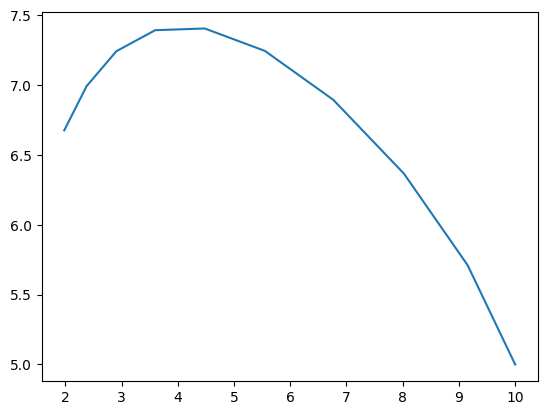

In [ ]:
shoot = 0
    #t_eval_curr = t_eval_all[np.where((measurement_indexes  >= shoot_indexes[shoot]) * (measurement_indexes  <= shoot_indexes[shoot + 1]))]
measurement_indexes_curr = measurement_indexes[np.where((measurement_indexes >= shoot_indexes[shoot]) * (measurement_indexes < shoot_indexes[shoot + 1]))]
t_eval_curr_measur = []
for id in measurement_indexes_curr:
    t_eval_curr_measur.append(t_eval_measurements[id])
t_eval_curr_measur = np.array(t_eval_curr_measur)

t0 = t_eval_curr_measur[0]
t1 = t_eval_measurements[measurement_indexes_curr[-1] + 1]
t_eval_curr = np.linspace(t0, t1, 10) 
c0 = theta[THETA_LENGTH + shoot * STATE_LENGTH : THETA_LENGTH +  (shoot + 1) * STATE_LENGTH]
solution = system.get_solution(c0, theta, (t0, t1), t_eval_curr, t_eval_curr_measur)

x = solution[0].y[0]  #for debug
y = solution[0].y[1] 
plt.plot(x, y)


In [ ]:
t_eval_curr_measur = []
for id in measurement_indexes_curr:
    t_eval_curr_measur.append(t_eval_measurements[id])
t_eval_curr_measur
t_eval_measurements[measurement_indexes_curr[-1] + 1]

7.884057971014493

In [ ]:
measurement_indexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

In [ ]:
shoot_indexes

array([ 0, 17, 34, 51, 68, 69])

In [ ]:
measurement_indexes_curr = measurement_indexes[np.where((measurement_indexes >= shoot_indexes[shoot]) * (measurement_indexes < shoot_indexes[shoot + 1]))]
measurement_indexes_curr

array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [ ]:
shoot = 3

In [ ]:
theta_true = np.array([alpha, beta, gamma, delta])
delta_theta = np.array([0.05, -0.11, 0.05, 0.01])
for i in range(len(shoot_indexes)-1 ):
    id = shoot_indexes[i]
    theta_true = np.concatenate((theta_true, [x_true[id], y_true[id]]))
    delta_theta = np.concatenate((delta_theta, np.zeros(STATE_LENGTH)))
theta_true

array([ 1.1       ,  0.4       ,  0.1       ,  0.1       , 10.        ,
        5.        ,  0.99108014,  4.86927725,  0.51347546,  2.51314392,
        1.05208037,  1.31547744,  3.97550805,  0.91448066])

In [ ]:
theta_true = np.array([alpha, beta, gamma, delta])
delta_theta = np.array([0.05, -0.11, 0.05, 0.01])
for i in range(len(shoot_indexes)-1 ):
    id = shoot_indexes[i]
    
    theta_true = np.concatenate((theta_true, [x_true_sample[id], x_true_sample[id]]))
    delta_theta = np.concatenate((delta_theta, np.zeros(STATE_LENGTH)))
theta_true

IndexError: index 126 is out of bounds for axis 0 with size 72

In [ ]:
measurement_indexes

array([  0,   7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
        91,  98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175,
       182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266,
       273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343, 350, 357,
       364, 371, 378, 385, 392, 399, 406, 413, 420, 427, 434, 441, 448,
       455, 462, 469, 476, 483, 490, 497])

In [ ]:
if()

array([  0, 126, 252, 378, 499])

In [ ]:
solution

(  message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 7.837e+00  8.000e+00]
         y: [[ 3.975e+00  4.482e+00]
             [ 9.145e-01  9.178e-01]
             ...
             [ 0.000e+00  1.591e-02]
             [ 1.000e+00  1.002e+00]]
       sol: None
  t_events: None
  y_events: None
      nfev: 26
      njev: 0
       nlu: 0,
   message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 7.837e+00]
         y: [[ 3.975e+00]
             [ 9.145e-01]
             ...
             [ 0.000e+00]
             [ 1.000e+00]]
       sol: None
  t_events: None
  y_events: None
      nfev: 26
      njev: 0
       nlu: 0)

In [ ]:
np.arange(0, N_points, max(int(N_points/N_measurement), 1), dtype=int )

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [ ]:
J_raw[2 + *(INDEX_C), i]

SyntaxError: invalid syntax (1113922671.py, line 1)

In [ ]:
**INDEX_C

SyntaxError: invalid syntax (2499938619.py, line 1)

In [ ]:
N_measurement = 70
measurement_indexes = np.arange(0, 500, int(500/N_measurement), dtype=int )
N_measurement = len(measurement_indexes)
# print(measurement_indexes)
shoot_indexes = measurement_indexes[0:-1:int(len(measurement_indexes)/1)]
indexes_all  = t_eval_all.argsort()
shoot_indexes = np.append(shoot_indexes, indexes_all[-1])
print(shoot_indexes)


[  0 499]


In [ ]:
theta_true = np.array([alpha, beta, gamma, delta])
delta_theta = np.array([0.05, -0.11, 0.05, 0.01])
for i in range(len(shoot_indexes) -1):
    id = shoot_indexes[i]
    theta_true = np.concatenate((theta_true, [x_true[id], y_true[id]]))
    delta_theta = np.concatenate((delta_theta, np.array([0.1, -0.15])))
theta_true
delta_theta

array([ 0.05, -0.11,  0.05,  0.01,  0.1 , -0.15,  0.1 , -0.15,  0.1 ,
       -0.15,  0.1 , -0.15])

In [ ]:
N_measurement = 70

measurement_indexes = np.arange(0, 500, int(500/N_measurement), dtype=int )
print(measurement_indexes)
shoot_indexes = measurement_indexes[0:-1:int(len(measurement_indexes)/4)]
shoot_indexes = np.append(shoot_indexes, indexes_all[-1])
print(shoot_indexes)


[  0   7  14  21  28  35  42  49  56  63  70  77  84  91  98 105 112 119
 126 133 140 147 154 161 168 175 182 189 196 203 210 217 224 231 238 245
 252 259 266 273 280 287 294 301 308 315 322 329 336 343 350 357 364 371
 378 385 392 399 406 413 420 427 434 441 448 455 462 469 476 483 490 497]
[  0 126 252 378 499]


In [ ]:
measurement_indexes[np.where((measurement_indexes > shoot_indexes[2]) * (measurement_indexes < shoot_indexes[3]))]

array([259, 266, 273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343,
       350, 357, 364, 371])

In [ ]:
measurement_indexes

array([  0,   7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
        91,  98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175,
       182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266,
       273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343, 350, 357,
       364, 371, 378, 385, 392, 399, 406, 413, 420, 427, 434, 441, 448,
       455, 462, 469, 476, 483, 490, 497])

In [ ]:
indexes_all  = t_eval_all.argsort()
for shoot in range(min(len(shoot_indexes) -1, 3)):
    t_eval_curr = t_eval_all[np.where((indexes_all  >= shoot_indexes[shoot]) * (indexes_all  <= shoot_indexes[shoot + 1]))]
    measurement_indexes_curr = measurement_indexes[np.where((measurement_indexes >= shoot_indexes[shoot]) * (measurement_indexes < shoot_indexes[shoot + 1]))]
    print(measurement_indexes_curr)
    print(t_eval_curr[0], t_eval_curr[-1])
    print(len(t_eval_curr))

[  0   7  14  21  28  35  42  49  56  63  70  77  84  91  98 105 112 119]
0.0 2.0200400801603204
127
[126 133 140 147 154 161 168 175 182 189 196 203 210 217 224 231 238 245]
2.0200400801603204 4.040080160320641
127
[252 259 266 273 280 287 294 301 308 315 322 329 336 343 350 357 364 371]
4.040080160320641 6.060120240480962
127


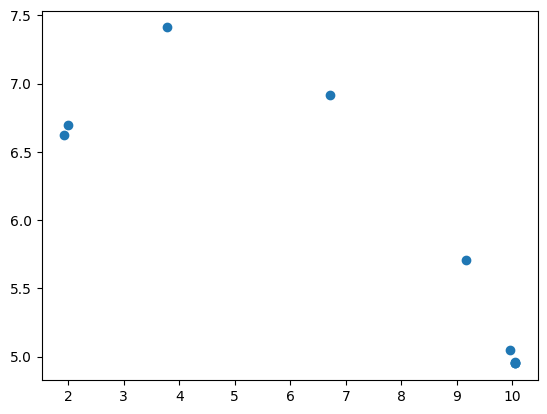

In [ ]:
plt.scatter(x_sample, y_sample)

In [ ]:
t_eval_all[np.all(np.where((t_eval_all.argsort() < shoot_indexes[1]) and \
          (t_eval_all.argsort() < shoot_indexes[1])))]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
np.where(t_eval_all.argsort() < shoot_indexes[1])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

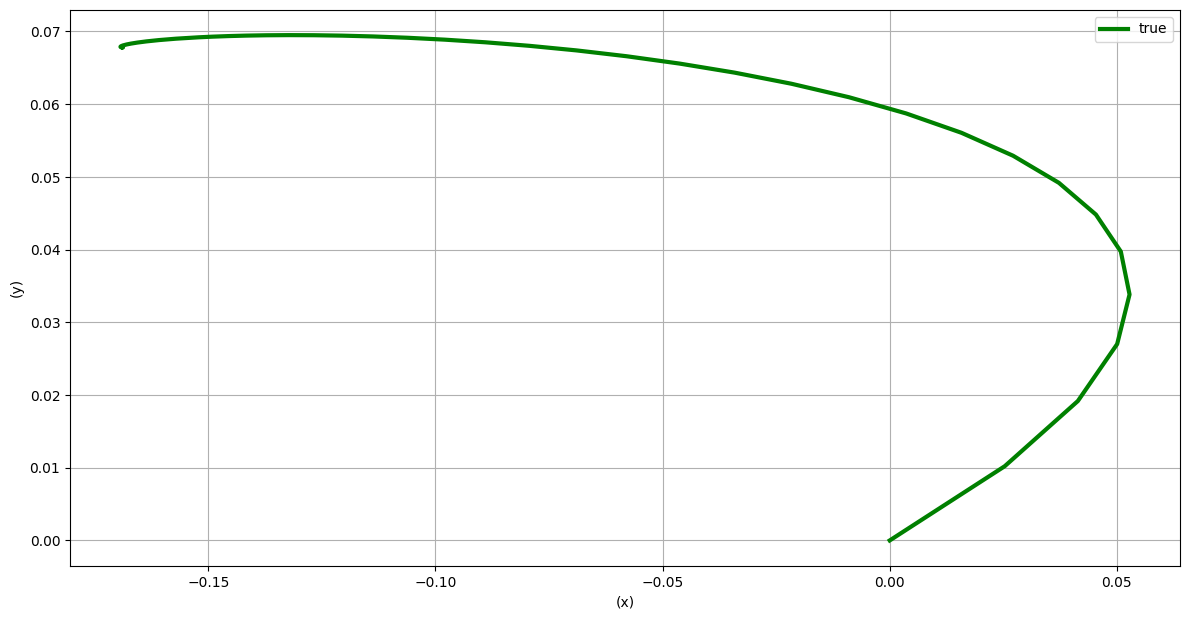

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

STATE_LENGTH = 2
THETA_LENGTH = 4

# Параметры модели
alpha = 1.1    # Скорость размножения жертв
beta = 0.4     # Скорость поедания жертв хищниками
gamma = 0.4    # Смертность хищников (без жертв)
delta = 0.1    # Скорость роста хищников (за счет жертв)

c0_true = np.array([10, 5])

theta_true = np.concatenate((np.array([alpha, beta, gamma, delta]), c0_true))

delta_theta = np.concatenate((np.array([0.05, -0.11, 0.05, 0.01]),  np.array([0.2, 0.1])))

theta = theta_true + delta_theta


theta =  np.array([190.84329002394486, 53.12192057033912, 67.81308698534674, 75.97577338173109])


T_max = 8
t_span = (0, T_max)
t_eval = np.linspace(0, T_max, 500)  # Точки для вывода решения
indexes = np.arange(30, 500, 50, dtype=int )
N_sample = len(indexes)

def lotka_volterra(state, theta, t):
    alpha, beta, gamma, delta, x0, y0 = theta
    x, y = state
    dx_dt = alpha * x - beta * x * y + t*0.2
    dy_dt = delta * x * y - gamma * y
    return [dx_dt, dy_dt]

def df_dtheta(state, theta):
    x, y = state
    return np.array([[x, -x * y, 0, 0, 0,0], [0, 0, -y,  x * y, 0, 0]])

def df_dx(state, theta):
    x, y = state
    alpha, beta, gamma, delta, x0, y0 = theta
    return np.array([[alpha - beta * y, -beta * x], [delta * y, delta * x - gamma]])

def make_full_system(state, theta, t):
    xy = state[:2]
    dJ_vec = state[2:]
    J = dJ_vec.reshape((2,6))
    dJ = df_dx(xy, theta)@J + df_dtheta(xy, theta)
    dstate = np.concatenate((lotka_volterra( xy, theta, t), dJ.flatten()))
    return dstate

def my_system(state, theta, t):
    a0, a1, b0, b1 = theta
    vy = state[0]
    wz = state[1]
    vx = 20
    wheelbase = 2.65
    delta = 0.01
    alpha_f = (vy + wheelbase * wz)/ vx
    alpha_r = (vy)/ vx

    vy_dot = a0 * (delta - alpha_f) + a1 * alpha_r - vx * wz 
    wz_dot = b0 * (delta - alpha_f) + b1 * alpha_r
    
    return [vy_dot, wz_dot]
# def JacobianX(state, theta):
#     xy = state[:STATE_LENGTH]
#     Jx = state[STATE_LENGTH : STATE_LENGTH + THETA_LENGTH * STATE_LENGTH].reshape((STATE_LENGTH, THETA_LENGTH))
#     dJx = df_dx(xy, theta)@Jx + df_dtheta(xy, theta)
#     return dJx.flatten()

# def JacobianC(state, theta):
#     xy = state[:STATE_LENGTH]
#     start_ind = STATE_LENGTH + THETA_LENGTH * STATE_LENGTH
#     end_ind = start_ind + STATE_LENGTH * STATE_LENGTH
#     Jc = state[start_ind: end_ind].reshape((STATE_LENGTH,STATE_LENGTH))
#     dJc = df_dx(xy, theta)@Jc
#     return dJc.flatten()

# def make_full_system(state, theta):
#     xy = state[: STATE_LENGTH]
#     dstate = np.concatenate((lotka_volterra( xy, theta), JacobianX(state, theta), JacobianC(state, theta)))
#     return dstate




J0 = np.concatenate((np.zeros((STATE_LENGTH, THETA_LENGTH)).flatten(), np.identity((STATE_LENGTH)).flatten()))
J0 = np.hstack((np.zeros((2, 4)), np.eye((2)))).flatten()
initial_conditions_true = np.concatenate((c0_true, J0))

# solution_true = solve_ivp(
#     lambda t, y: lotka_volterra(y, theta_true, t),
#     t_span,
#     c0_true,
#     t_eval = t_eval,
#     method='RK45'  # Метод Рунге — Кутты 4-5 порядка
# )

# solution_true = solve_ivp(
#     lambda t, y: make_full_system(y, theta_true, t),
#     t_span,
#     initial_conditions_true,
#     t_eval = t_eval,
#     method='RK45'  # Метод Рунге — Кутты 4-5 порядка
# )

solution_true = solve_ivp(
    lambda t, y: my_system(y, theta, t),
    t_span,
    [0, 0],
    t_eval = t_eval,
    atol= 1e-6,
    rtol= 1e-6,
    method='RK45'  # Метод Рунге — Кутты 4-5 порядка
)

x_true = solution_true.y[0]  
y_true = solution_true.y[1]  
t_true = solution_true.t      

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax1.grid()
if(0):
    delta_theta_estimate = np.zeros_like(theta)

    x_true_sample = x_true[indexes] + (np.random.random(N_sample) - 0.5)*0.0
    y_true_sample = y_true[indexes] + (np.random.random(N_sample) - 0.5)*0.0


    N_iter = 10
    THETA_HIST = []
    for iter in range(N_iter + 1):
        theta = theta - delta_theta_estimate
        #c0 = c0 - delta_theta_estimate[-2:]
        c0 = theta[4:6]
        initial_conditions = np.hstack((c0, J0))
        system = lambda t, y: make_full_system(y, theta, t)
        solution = solve_ivp(
            system,
            t_span,
            initial_conditions,
            t_eval = t_eval,
            method='RK45'  
        )


        x = solution.y[0]  
        y = solution.y[1]  
        x_sample = x[indexes]
        y_sample = y[indexes]

        J_raw = solution.y[2:]

        J = np.zeros((N_sample, 2, 6))
        res1 = -np.vstack((x_true_sample - x_sample, y_true_sample - y_sample )).T
        for i in range(N_sample):
            ind = indexes[i]
            J[i] = J_raw[:, ind].reshape((2, 6))[:, :]
            #J[i] = np.hstack((J_raw[:8, ind].reshape(2, 4), J_raw[8:12, ind].reshape(2, 2)))#J_raw[:, ind].reshape((2, 6))[:, :]

        delta_theta_estimate = minimize(lambda theta_: np.linalg.norm(J@theta_ - res1) , np.zeros(6)).x

        print(delta_theta_estimate)
        THETA_HIST.append(theta - theta_true)


        ax1.plot(solution.y[0], solution.y[1], label=f'$iter_{iter}$')
        #ax1.scatter(x_sample, y_sample)
        
    THETA_HIST = np.array(THETA_HIST)
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot([*range(N_iter+ 1)], THETA_HIST)
    ax2.set_xlabel('iter')
    ax2.set_ylabel(r'$\Delta \theta$')
    ax2.legend()


ax1.set_xlabel('(x)')
ax1.set_ylabel('(y)')
# ax1.scatter(x_true_sample, y_true_sample, color='green')
# ax1.scatter(c0_true[0], c0_true[1], marker='X')
ax1.plot(x_true, y_true, color='green', label = "true", linewidth=3)
ax1.legend()


# plt.subplot(2, 2, 2)



ax2.grid()
plt.tight_layout()
plt.show()

In [ ]:
#print(x_true)
print(y_true)

[0.00000000e+00 1.92944898e-03 4.17580187e-03 6.90805048e-03
 1.03767879e-02 1.49613392e-02 2.12327106e-02 3.00247589e-02
 4.26183742e-02 6.09494048e-02 8.78368197e-02 1.27508079e-01
 1.86588425e-01 2.74622596e-01 4.05702247e-01 6.01900659e-01
 8.96026560e-01 1.33588084e+00 1.99353530e+00 2.98180569e+00
 4.46286692e+00 6.67653116e+00 9.99857137e+00 1.49868457e+01
 2.24544395e+01 3.36287751e+01 5.04284465e+01 7.56113102e+01
 1.13258529e+02 1.69769930e+02 2.54626106e+02 3.81654299e+02
 5.71770102e+02 8.57599527e+02 1.28602854e+03 1.92651235e+03
 2.88808013e+03 4.33181867e+03 6.49283910e+03 9.72763450e+03
 1.45909575e+04 2.18798886e+04 3.27765228e+04 4.91383128e+04
 7.37022334e+04 1.10465836e+05 1.65505942e+05 2.48254048e+05
 3.72261623e+05 5.57648701e+05 8.36056986e+05 1.25398990e+06
 1.87941702e+06 2.81593037e+06 4.22385733e+06 6.33361014e+06
 9.48766620e+06 1.42249919e+07 2.13357296e+07 3.19755726e+07
 4.79105253e+07 7.18656810e+07 1.07759037e+08 1.61420474e+08
 2.42029534e+08 3.630117

In [ ]:
solution_true1 = solve_ivp(
    lambda t, y: lotka_volterra(y, theta_true),
    t_span,
    c0_true,
    t_eval = t_eval,
    method='RK45'  # Метод Рунге — Кутты 4-5 порядка
)

solution_true2 = solve_ivp(
    lambda t, y: make_full_system(y, theta_true),
    t_span,
    initial_conditions_true,
    t_eval = t_eval,
    method='RK45'  # Метод Рунге — Кутты 4-5 порядка
)


NameError: name 't_span' is not defined

In [ ]:
print(solution_true1.y[0] - solution_true2.y[0])

[ 0.00000000e+00 -2.63495799e-07 -4.46560083e-07  1.18536930e-06
  3.63431671e-06  4.96032797e-06  4.53682606e-06  3.99308001e-05
  4.03460848e-04  1.10693272e-03  2.08927401e-03  3.29134021e-03
  4.65591467e-03  6.12770864e-03  7.65307975e-03  9.18355301e-03
  1.06758298e-02  1.20898496e-02  1.33887858e-02  1.45390464e-02
  1.55102733e-02  1.62753429e-02  1.68103656e-02  1.70946862e-02
  1.71108836e-02  1.68447710e-02  1.62853958e-02  1.54250397e-02
  1.42592185e-02  1.27866824e-02  1.10094156e-02  8.93263664e-03
  6.56479839e-03  3.91758783e-03  1.00592619e-03 -2.15203107e-03
 -5.54725594e-03 -9.18290509e-03 -1.30273611e-02 -1.70477429e-02
 -2.12116029e-02 -2.54869270e-02 -2.98421348e-02 -3.42460792e-02
 -3.86680466e-02 -4.30777571e-02 -4.74453640e-02 -5.17414544e-02
 -5.59370489e-02 -6.00036012e-02 -6.39129991e-02 -6.76375635e-02
 -7.11500488e-02 -7.44236432e-02 -7.74319681e-02 -8.01490786e-02
 -8.25494632e-02 -8.46080440e-02 -8.63001765e-02 -8.76016497e-02
 -8.84886863e-02 -8.89379

In [ ]:
N_points = len(measurement_indexes)
N_shoot = 2
n = int(N_points/(N_shoot+1))
shoot_indexes = measurement_indexes[n:N_points - n: n]
shoot_indexes

array([168, 324])

In [ ]:
step_dt

12

In [ ]:
step_measurement = int(step_dt/5)
np.arange(0, indexes[0], step_measurement, dtype = int)
np.arange(indexes[0] + step_measurement, indexes[1] - step_measurement, step_measurement, dtype = int)

array([199, 232, 265, 298])

In [ ]:
step_measurement

33

In [ ]:
np.hstack((J_raw[:8, ind].reshape(2, 4), J_raw[8:12, ind].reshape(2, 2)))


array([[  3.62676652, -20.52815001,   1.54714246, -14.85416556,
          0.63239898,  -1.22745639],
       [  0.69965794,  -3.75748691,  -2.88572094,  26.6469371 ,
          0.28736893,   1.09027761]])

In [ ]:
 J_raw[8:12, ind].reshape(2, 2)

array([[ 0.        , -1.21699483],
       [ 0.        , -0.20798228]])

[ 0.05809926 -0.07248778  0.05062625 -0.0018383   0.88040107  0.27290407] [ 1.15  0.29  0.45  0.11 10.2   5.1 ]
[-0.01175512 -0.03476412  0.00074366  0.00986551 -0.53757075 -0.1384095 ] [1.09190074 0.36248778 0.39937375 0.1118383  9.31959893 4.82709593]
[ 0.00355969 -0.00273241 -0.00132875  0.00196697 -0.14026514 -0.0341176 ] [1.10365586 0.39725189 0.39863009 0.10197279 9.85716968 4.96550543]
[ 9.71394845e-05 -1.51669070e-05 -4.26257527e-05  4.70785512e-06
 -2.52721087e-03 -3.59038820e-04] [1.10009617 0.3999843  0.39995884 0.10000582 9.99743482 4.99962303]
[ 5.07426499e-08 -1.56576021e-07 -2.89370360e-08 -1.71146442e-08
 -1.46641686e-10  4.33551549e-09] [1.09999903 0.39999947 0.40000146 0.10000112 9.99996203 4.99998207]
[-1.97523824e-09  2.64467903e-08  4.41339371e-09 -2.26534569e-09
 -7.82062237e-10  2.73401510e-09] [1.09999898 0.39999963 0.40000149 0.10000113 9.99996203 4.99998206]


/tmp/ipykernel_56959/2906487251.py:129: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


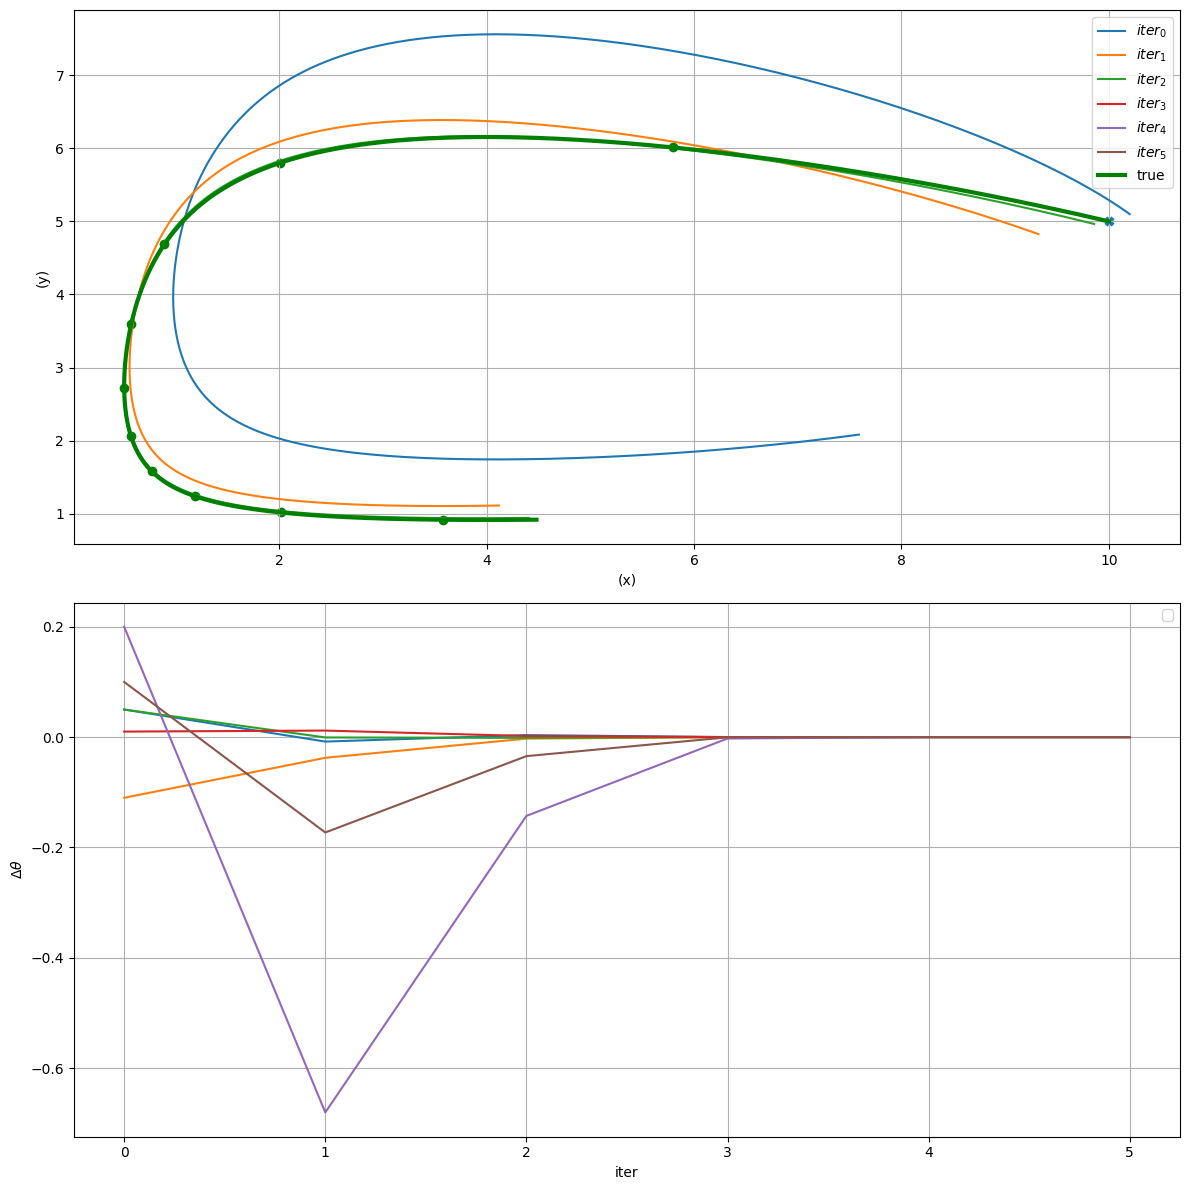

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# Параметры модели
alpha = 1.1    # Скорость размножения жертв
beta = 0.4     # Скорость поедания жертв хищниками
gamma = 0.4    # Смертность хищников (без жертв)
delta = 0.1    # Скорость роста хищников (за счет жертв)

c0_true = np.array([10, 5])

theta_true = np.concatenate((np.array([alpha, beta, gamma, delta]), c0_true))



delta_theta = np.concatenate((np.array([0.05, -0.11, 0.05, 0.01]),  np.array([0.2, 0.1])))

theta = theta_true + delta_theta


T_max = 8
t_span = (0, T_max)
t_eval = np.linspace(0, T_max, 500)  # Точки для вывода решения
indexes = np.arange(30, 500, 50, dtype=int )
N_sample = len(indexes)

def lotka_volterra(state, theta):
    alpha, beta, gamma, delta, x0, y0 = theta
    x, y = state
    dx_dt = alpha * x - beta * x * y
    dy_dt = delta * x * y - gamma * y
    return [dx_dt, dy_dt]

def df_dtheta(state, theta):
    x, y = state
    return np.array([[x, -x * y, 0, 0, 0,0], [0, 0, -y,  x * y, 0, 0]])

def df_dx(state, theta):
    x, y = state
    alpha, beta, gamma, delta, x0, y0 = theta
    return np.array([[alpha - beta * y, -beta * x], [delta * y, delta * x - gamma]])

def make_full_system(state, theta):
    xy = state[:2]
    dJ_vec = state[2:]
    J = dJ_vec.reshape((2,6))
    dJ = df_dx(xy, theta)@J + df_dtheta(xy, theta)
    dstate = np.concatenate((lotka_volterra( xy, theta), dJ.flatten()))
    return dstate


J0 = np.hstack((np.zeros((2, 4)), np.identity((2)))).flatten()
initial_conditions_true = np.hstack((c0_true, J0))

solution_true = solve_ivp(
    lambda t, y: make_full_system(y, theta_true),
    t_span,
    initial_conditions_true,
    t_eval = t_eval,
    method='RK45'  # Метод Рунге — Кутты 4-5 порядка
)

x_true = solution_true.y[0]  
y_true = solution_true.y[1]  
t_true = solution_true.t      

delta_theta_estimate = np.zeros_like(theta)

x_true_sample = x_true[indexes] + (np.random.random(N_sample) - 0.5)*0.0
y_true_sample = y_true[indexes] + (np.random.random(N_sample) - 0.5)*0.0

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax1.grid()
N_iter = 5
THETA_HIST = []
for iter in range(N_iter + 1):
    theta = theta - delta_theta_estimate
    #c0 = c0 - delta_theta_estimate[-2:]

    c0 = theta[4:6]
    initial_conditions = np.hstack((c0, J0))
    system = lambda t, y: make_full_system(y, theta)
    solution = solve_ivp(
        system,
        t_span,
        initial_conditions,
        t_eval = t_eval,
        method='RK45'  
    )

    x = solution.y[0]  
    y = solution.y[1]  
    x_sample = x[indexes]
    y_sample = y[indexes]

    J_raw = solution.y[2:]

    J = np.zeros((N_sample, 2, 6))
    res1 = -np.vstack((x_true_sample - x_sample, y_true_sample - y_sample )).T
    for i in range(N_sample):
        ind = indexes[i]
        J[i] = J_raw[:, ind].reshape((2, 6))[:, :]



    delta_theta_estimate = minimize(lambda theta_: np.linalg.norm(J@theta_ - res1) , np.zeros(6)).x

    print(delta_theta_estimate, theta)
    THETA_HIST.append(theta - theta_true)


    ax1.plot(solution.y[0], solution.y[1], label=f'$iter_{iter}$')
    #ax1.scatter(x_sample, y_sample)

THETA_HIST = np.array(THETA_HIST)
ax1.set_xlabel('(x)')
ax1.set_ylabel('(y)')
ax1.scatter(x_true_sample, y_true_sample, color='green')
ax1.scatter(c0_true[0], c0_true[1], marker='X')
ax1.plot(x_true, y_true, color='green', label = "true", linewidth=3)
ax1.legend()

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot([*range(N_iter+ 1)], THETA_HIST)
ax2.set_xlabel('iter')
ax2.set_ylabel(r'$\Delta \theta$')
ax2.legend()
# plt.subplot(2, 2, 2)



ax2.grid()
plt.tight_layout()
plt.show()